# <center> Butter-E Dataset Notebooks: Regression Model and Plots </center>
---


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import plotly.express as px

import pyarrow.parquet as pq

import matplotlib.colors
import random

import scipy
import scipy.interpolate

from pprint import pprint
from pandas.api.types import is_numeric_dtype

from common import *

/home/ctripp/gcomp/env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 1. Load data

In [2]:
experiments = pd.read_parquet("data_artifacts/experiments.pq")

# 4. Plots

In [3]:
from pandas.api.types import is_numeric_dtype


def compute_quantiles(interpolation_x, x, y, window_size, min_window_population=50):
    def compute_quantiles_for_value(x_value):
        deltas = np.abs(x - float(x_value))
        window_mask = deltas <= window_size
        window = y.loc[window_mask].to_numpy()
        if len(window) < min_window_population:
            return np.array([np.nan] * 4)
        v = [x_value] + np.quantile(window, [0.25, 0.5, 0.75]).tolist()
        return v

    quantile_data = [
        value
        for value in (
            compute_quantiles_for_value(x_value) for x_value in interpolation_x
        )
        if not pd.isna(value[0])
    ]
    quantiles = np.fromiter(
        quantile_data,
        dtype=np.dtype((np.float32, 4)),
        count=len(quantile_data),
    )
    return quantiles


def compute_moving_average(x, window_size=1):
    def func(i):
        window = x[max(0, i - window_size) : min(x.shape[0], i + window_size)]
        return np.average(window)

    return np.fromiter((func(i) for i in range(x.shape[0])), dtype=np.float32)


def compute_moving_averages_of_windowed_quantiles(
    x,
    y,
    resolution=500,
    min_window_population=50,
    quantile_window_size=1,
    moving_average_window_size=None,
):
    print(f"{x.min()} {x.max()} {resolution}")
    interpolation_stepsize = (x.max() - x.min()) / (resolution - 1)
    interpolation_x = np.arange(x.min(), x.max(), interpolation_stepsize)
    if moving_average_window_size is None:
        moving_average_window_size = int(
            np.round(quantile_window_size / interpolation_stepsize)
        )
    quantiles = compute_quantiles(
        interpolation_x, x, y, quantile_window_size, min_window_population
    )
    for i in range(1, 4):
        quantiles[:, i] = compute_moving_average(
            quantiles[:, i], moving_average_window_size
        )
    return quantiles


def regression_plotter(e, facet):
    fig, axs = plt.subplots(
        1,
        1,
        figsize=(12, 12),
        constrained_layout=True,
    )
    ax = axs

    facets = sorted(e[facet].unique())
    if is_numeric_dtype(e[facet].dtype):
        colors = matplotlib.colormaps.get_cmap("winter")(np.linspace(0, 1, len(facets)))
    else:
        colors = matplotlib.colormaps.get_cmap("tab20")(np.linspace(0, 1, len(facets)))

    if len(facets) <= 20:
        lines = []
        for r, (facet_value, color) in enumerate(zip(facets, colors)):
            s = e.loc[e[facet] == facet_value]
            lines.append(
                ax.scatter(s["x"], s["y"], s=25.0, marker=".", alpha=0.8, color=color)
            )

        legend_names = [f"{facet}: {value}" for value in facets]
        legend_lines = lines
        if len(facets) > 20:
            legend_names = [legend_names[0], legend_names[-1]]
            legend_lines = [legend_lines[0], legend_lines[-1]]
        ax.legend(legend_lines, legend_names)
    else:
        colormap = {facet_value: color for facet_value, color in zip(facets, colors)}
        ax.scatter(
            e["x"],
            e["y"],
            s=25.0,
            marker=".",
            alpha=0.4,
            color=e[facet].transform(lambda x: colormap[x]),
        )
        ax.legend(
            [
                plt.Line2D([0], [0], color=colors[0], lw=4),
                plt.Line2D([0], [0], color=colors[(len(colors) * 2) // 3], lw=4),
                plt.Line2D([0], [0], color=colors[len(colors) // 2], lw=4),
                plt.Line2D([0], [0], color=colors[(len(colors) * 2) // 3], lw=4),
                plt.Line2D([0], [0], color=colors[-1], lw=4),
            ],
            [
                f"{facet}: {value}"
                for value in [
                    facets[0],
                    facets[(len(facets)) // 3],
                    facets[len(facets) // 2],
                    facets[(len(facets) * 2) // 3],
                    facets[-1],
                ]
            ],
        )

    return fig, ax


def plot_regression(e, facet):
    e["x"] = e["non_overhead_energy"]
    e["y"] = e["estimated_energy"]
    fig, ax = regression_plotter(e, facet)

    ax.plot(e["x"], e["x"], "k", lw=4, alpha=0.5)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title("Regression")
    ax.set_xlabel("Actual Energy")
    ax.set_ylabel("Estimated Energy")
    plt.show()


def plot_regression_per_batch(e, facet):
    e["x"] = e["energy_per_training_batch"]
    e["y"] = e["estimated_energy_per_batch"]
    fig, ax = regression_plotter(e, facet)

    ax.plot(e["x"], e["x"], "k", lw=4, alpha=0.5)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_title("Regression")
    ax.set_xlabel("Actual Energy")
    ax.set_ylabel("Estimated Energy")
    plt.show()


def plot_regression_residual_per_batch(e, facet):
    e["error"] = np.log10(e["estimated_energy_per_batch"]) - np.log10(
        e["energy_per_training_batch"]
    )
    e["y"] = e["error"]
    e["x"] = e[facet]
    fig, ax = regression_plotter(e, "dataset")

    ax.plot(e["x"], e["x"] * 0, "k", lw=4, alpha=0.4)

    ax.set_xscale("log")
    ax.set_title("Residuals")
    ax.set_ylabel("Residual")
    ax.set_xlabel(facet)
    plt.show()


def plot_regression_residual(e, facet, color_by="dataset"):
    e["error"] = e["relative_error"]
    e["y"] = e["error"]
    e["x"] = e[facet]
    if is_numeric_dtype(e[facet].dtype):
        e["x"] = np.maximum(-1e12, np.log2(e[facet]))

    fig, ax = regression_plotter(e, color_by)

    ax.plot(e["x"], e["x"] * 0, "k", lw=4, alpha=0.4)

    if is_numeric_dtype(e[facet].dtype):
        moving_averages = compute_moving_averages_of_windowed_quantiles(
            e["x"],
            e["y"],
            resolution=200,
            min_window_population=10,
            quantile_window_size=1,
        )

        x = moving_averages[:, 0]

        ax.plot(
            x,
            moving_averages[:, 2],
            color="k",
            lw=3,
            alpha=0.9,
        )

        ax.fill_between(
            x,
            moving_averages[:, 1],
            moving_averages[:, 3],
            color="k",
            alpha=0.2,
        )

    ax.set_title("Residuals")
    ax.set_ylabel("Residual")
    ax.set_xlabel(facet)
    plt.show()


def plot_regression_residual_2(e, facet):
    e["error"] = np.log10(e["non_overhead_energy"]) - np.log10(e["estimated_energy"])
    e["x"] = e["estimated_energy"]
    e["y"] = e["error"]

    fig, ax = regression_plotter(e, facet)

    ax.plot(e["x"], e["x"] * 0, "k", lw=4, alpha=0.6)
    ax.set_xscale("log")
    ax.set_title("Residuals")
    ax.set_ylabel("Residual")
    ax.set_xlabel("Estimated Energy")
    plt.show()

In [4]:
pprint(list(experiments.columns))

['experiment_id',
 'depth',
 'size',
 'run_time',
 'energy',
 'power',
 'std_energy',
 'std_power',
 'energy_overhead',
 'non_overhead_energy',
 'runtime_overhead',
 'non_overhead_runtime',
 'has_gpu',
 'median_idle_power_for_type',
 'idle_power',
 'node',
 'dataset',
 'shape',
 'type',
 'n_observations',
 'n_features',
 'n_classes',
 'Endpoint',
 'Imbalance',
 'Task',
 'Metadata',
 'num_free_parameters',
 'widths',
 'num_runs',
 'task',
 'batch_size',
 'learning_rate',
 'test_loss_best_quantile_0',
 'epoch',
 'test_loss_best_quantile_25',
 'test_loss_best_quantile_50',
 'test_loss_best_quantile_75',
 'test_loss_best_quantile_100',
 'num_epochs',
 'full_widths',
 'num_nodes',
 'log_size',
 'log_parameters',
 'num_training_batches_per_epoch',
 'num_test_batches_per_epoch',
 'num_batches_per_epoch',
 'energy_per_training_batch',
 'energy_per_training_datum',
 'log10_energy_per_training_datum',
 'seconds_per_training_batch',
 'log10_energy_per_training_batch',
 'traning_data_per_epoch',
 

In [5]:
pprint([c for c in experiments.columns if "parameter2x_dataset" in c])

[]


In [6]:
def cpu_cache_energy_plot(
    df,
    x,
    y=None,
    y2=None,
    draw_cache_lines=True,
    fit_each_cache_level=False,
    hue="depth",
    alpha=0.2,
):

    if y is None:
        y = np.log2(
            df["energy_per_training_batch"]
        )  # - .9 * df["energy_per_training_batch"].min())
        energy_effect_plot(df, x, y, draw_cache_lines, hue, fit_each_cache_level, alpha)

    # if y2 is None:
    #     y2 = np.log2(df["seconds_per_training_batch"] )#- .9 * df["seconds_per_training_batch"].min())
    #     energy_effect_plot(df, x, y2, draw_cache_lines, hue, alpha)


def energy_effect_plot(
    df, x, y, draw_cache_lines=True, hue="depth", fit_each_cache_level=False, alpha=0.2
):

    mask = (y > -np.inf) & (x > -np.inf)
    print(f"filtering {np.sum(~mask)} of {len(mask)}")
    df = df.loc[mask]
    x = x.loc[mask]
    y = y.loc[mask]

    fig, axs = plt.subplots(2, 1, figsize=(20, 40))

    ax = axs[0]
    sns.scatterplot(
        data=df,
        x=x,
        y=y,
        # hue= (df.apply(lambda r : 1+ np.max(np.maximum(0, r["fwd_output_ws"])), axis=1) > cpu_level_1_bytes_per_core),
        # hue=(df["num_free_parameters"] * 4 * 2 > gpu_level_2_bytes_per_gpu),
        hue=hue,
        # hue="dataset",
        ax=ax,
        alpha=alpha,
    )
    moving_averages = compute_moving_averages_of_windowed_quantiles(
        x,
        y,
        resolution=200,
        min_window_population=5,
        quantile_window_size=0.5,
    )

    x_ma = moving_averages[:, 0]
    y_ma = moving_averages[:, 2]

    ax.plot(
        x_ma,
        y_ma,
        color="k",
        lw=3,
        alpha=0.9,
    )

    ax.fill_between(
        x_ma,
        moving_averages[:, 1],
        moving_averages[:, 3],
        color="k",
        alpha=0.2,
    )

    if draw_cache_lines == "gpu":
        cache_sizes = gpu_cache_sizes
    else:
        cache_sizes = cpu_cache_sizes

    if draw_cache_lines:
        for cache_size in cache_sizes:
            ax.axvline(np.log2(cache_size), color="r")

    def do_fit(x_ma, y_ma, df, ax, ax2):
        expx = np.power(2, x_ma)
        expy = np.power(2, y_ma)

        # expx = np.power(2, x)
        # expy = np.power(2, y)

        def estimation_function(costs, x):
            return costs[0] + costs[1] * x

        def cost_function(costs):
            # return (estimation_function(costs, expx) - expy) / expy
            return (estimation_function(costs, x_ma) - expy) / np.miniumum(expx, expy)

        # try:
        result = scipy.optimize.least_squares(
            cost_function,
            [0, 1],
            x_scale="jac",
            # loss="soft_l1",
            jac="3-point",
            method="trf",
            ftol=1e-15,
            xtol=1e-15,
            gtol=1e-15,
        )

        print(result.x)
        fit_x = np.linspace(x_ma.min(), x_ma.max(), 100)
        fit_y = np.log2(result.x[0] + result.x[1] * np.power(2, fit_x))
        ax.plot((fit_x), (fit_y), color="r", lw=2, alpha=0.5)

        ax2.plot((fit_y), (fit_y), color="r", lw=2, alpha=0.5)
        sns.scatterplot(
            data=df,
            x=np.log2(estimation_function(result.x, np.power(2, x))),
            y=y,
            # hue= (df.apply(lambda r : 1+ np.max(np.maximum(0, r["fwd_output_ws"])), axis=1) > cpu_level_1_bytes_per_core),
            # hue=(df["num_free_parameters"] * 4 * 2 > gpu_level_2_bytes_per_gpu),
            hue=hue,
            # hue="dataset",
            ax=ax2,
            alpha=alpha,
        )
        ax2.set_xlabel("Estimated energy")
        ax2.set_ylabel("Measured energy")
        # except:
        #     pass

    if fit_each_cache_level:
        last_size = 0
        for cache_size in cache_sizes + [16 * (2**20 * 96)]:
            mask = (x_ma >= np.log2(last_size)) & (x_ma < np.log2(cache_size))
            print(
                f"fitting working set range {last_size} to {cache_size} , with {np.sum(mask)} entries"
            )
            if np.sum(mask) > 2:
                do_fit(
                    x_ma[mask],
                    y_ma[mask],
                    df.loc[(x >= np.log2(last_size)) & (x < np.log2(cache_size))],
                    ax,
                    axs[1],
                )
            last_size = cache_size
    else:
        if len(x_ma) > 2:
            do_fit(x_ma, y_ma, df, ax, axs[1])

    plt.show()

In [7]:
def fit_model(e, caches, cache_io):

    def estimation_function(costs):

        def compute_batch_cost(
            m1,
            m2,
            m3,
            operations,
            batch_working_set_cache_level,
            batch_working_set_cache_size,
        ):
            i = 1
            batch_cost = costs[i]
            i += 1
            batch_cost += (operations / 1e9) * costs[i]
            i += 1
            batch_cost += e["depth"] * costs[i] * m1
            i += 1

            dataset_bytes_accessed_per_batch = e["bytes_per_datum"] * e["batch_size"]

            s = i
            initiation_cost_accumulator = 0
            marginal_cost_accumulator = 0
            for j, (level, size, number) in enumerate(caches):
                # initiation_cost = 0
                initiation_cost = costs[i]
                marginal_cost = costs[i + len(caches)] * number / 1024**2
                # marginal_cost = 0

                # initiation_cost_accumulator += costs[i]
                # initiation_cost = initiation_cost_accumulator / 1024**2

                # marginal_cost_accumulator += costs[i + len(caches)] / 1024**3
                # marginal_cost = marginal_cost_accumulator

                # initiation_cost = sum(costs[s:s+j+1])
                # marginal_cost = sum(costs[s+len(caches):s+j+1+len(caches)])

                i += 1

                batch_cost += (e[batch_working_set_cache_level] == level) * (
                    initiation_cost * e["depth"] * m1
                    + marginal_cost * e[batch_working_set_cache_size] * m2
                )

                if level >= cache_io:
                    interlayer_transfer_count = e[
                        f"per_layer_interlayer_working_set_cache_level_{level}_count"
                    ]
                    interlayer_transfer_bytes = e[
                        f"per_layer_interlayer_working_set_cache_level_{level}_size"
                    ]
                    batch_cost += initiation_cost * (
                        interlayer_transfer_count * m3 - 1
                    ) + marginal_cost * (
                        interlayer_transfer_bytes * m3
                        - dataset_bytes_accessed_per_batch
                    )

                # if level > 1:
                batch_cost += (e["epoch_working_set_cache_level"] == level) * (
                    initiation_cost + dataset_bytes_accessed_per_batch * marginal_cost
                )

            return batch_cost

        train_batch_cost = compute_batch_cost(
            1,
            1,
            1,
            e["fwd_operations"],
            "bwd_pass_working_set_cache_level",
            "fwd_pass_working_set_cached_size",
        )

        train_batch_cost += compute_batch_cost(
            1,
            1,
            1,
            e["bwd_operations"],
            "bwd_pass_working_set_cache_level",
            "bwd_pass_working_set_cached_size",
        )

        test_batch_cost = compute_batch_cost(
            1,
            1,
            1,
            e["fwd_operations"],
            "fwd_pass_working_set_cache_level",
            "fwd_pass_working_set_cached_size",
        )

        return np.maximum(
            1e-12,
            costs[0]
            + (
                e["num_training_batches_per_epoch"] * train_batch_cost
                + e["num_test_batches_per_epoch"] * test_batch_cost
            ),
        )

    def error_func(costs):
        estimated_energy = estimation_function(costs)
        actual_energy = e["non_overhead_energy"].to_numpy()
        # return (estimated_energy - actual_energy) / actual_energy
        # return (estimated_energy - actual_energy) / np.minimum(estimated_energy, actual_energy)
        return np.log(estimated_energy / actual_energy)

    initial = np.ones(
        (4 + len(caches) * 2),
        dtype=np.float64,
    )

    low_bound = 0 * initial
    low_bound[0] = -1e5
    high_bound = initial * np.inf

    result = scipy.optimize.least_squares(
        error_func,
        initial,
        x_scale="jac",
        bounds=(
            low_bound,
            high_bound,
        ),
        # loss="soft_l1",
        jac="3-point",
        method="trf",
        ftol=1e-15,
        xtol=1e-15,
        gtol=1e-15,
    )

    pprint(list(enumerate(result.x)))
    e["estimated_energy"] = estimation_function(result.x)

    e["log_num_nodes"] = np.log2(e["num_nodes"])
    e["log_num_free_parameters"] = np.log2(e["num_free_parameters"])

    e["residual"] = np.log(e["non_overhead_energy"]) - np.log(e["estimated_energy"])
    e["residual_abs"] = np.abs(e["residual"])

    e["relative_error"] = (e["non_overhead_energy"] - e["estimated_energy"]) / e[
        "non_overhead_energy"
    ]
    e["relative_error_abs"] = np.abs(e["relative_error"])

    print(f"error: {e['residual_abs'].mean()} {100 * e['relative_error_abs'].mean()}%")

    return result, estimation_function, e

In [8]:
def make_parameter_values(caches, result):

    parameter_names = (
        ["k_e", "k_p", "k_o", "k_d"]
        + [f"a_{level}" for level, size, number in caches]
        + [f"m_{level}" for level, size, number in caches]
    )
    parameter_map = {
        name: value for name, value in zip(parameter_names, list(result.x))
    }

    result = [(name, parameter_map[name]) for name in parameter_names]
    pprint(result)
    return result

In [9]:
gpu_experiments = (
    experiments.query('has_gpu == 1 and dataset not in ("505_tecator")')
    .copy()
    .reset_index(drop=True)
)

gpu_result, gpu_estimation_function, gpu_experiments = fit_model(
    gpu_experiments, gpu_caches, 0
)
gpu_parameters = make_parameter_values(gpu_caches, gpu_result)
# 5.381787204622853%
# 5.428474944759457%

[(0, 614.4530033811986),
 (1, 3077.6164787571547),
 (2, 889.8504700398178),
 (3, 33.08340239086024),
 (4, 16.397627884684717),
 (5, 19.770274134099086),
 (6, 4.979016243554132e-25),
 (7, 2.4519218164303315e-29),
 (8, 4.346489120617996e-28),
 (9, 5.715811019061141)]
error: 0.05411657966795069 5.433567083057405%
[('k_e', 614.4530033811986),
 ('k_p', 3077.6164787571547),
 ('k_o', 889.8504700398178),
 ('k_d', 33.08340239086024),
 ('a_1', 16.397627884684717),
 ('a_2', 19.770274134099086),
 ('a_3', 4.979016243554132e-25),
 ('m_1', 2.4519218164303315e-29),
 ('m_2', 4.346489120617996e-28),
 ('m_3', 5.715811019061141)]


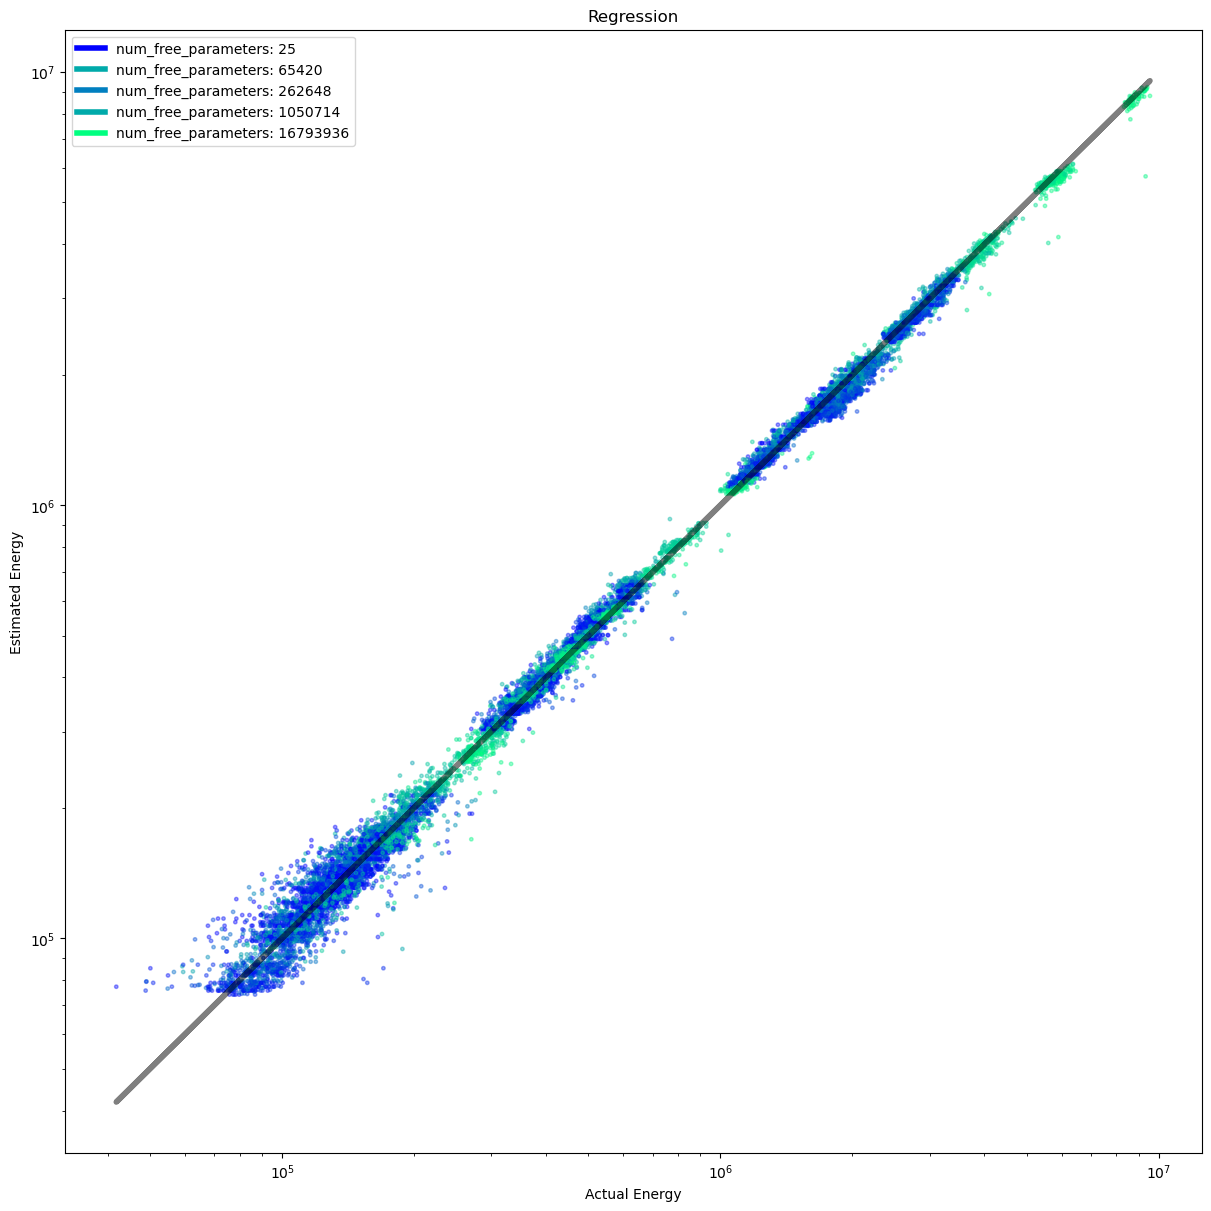

4.643856189774724 24.001437059001024 200


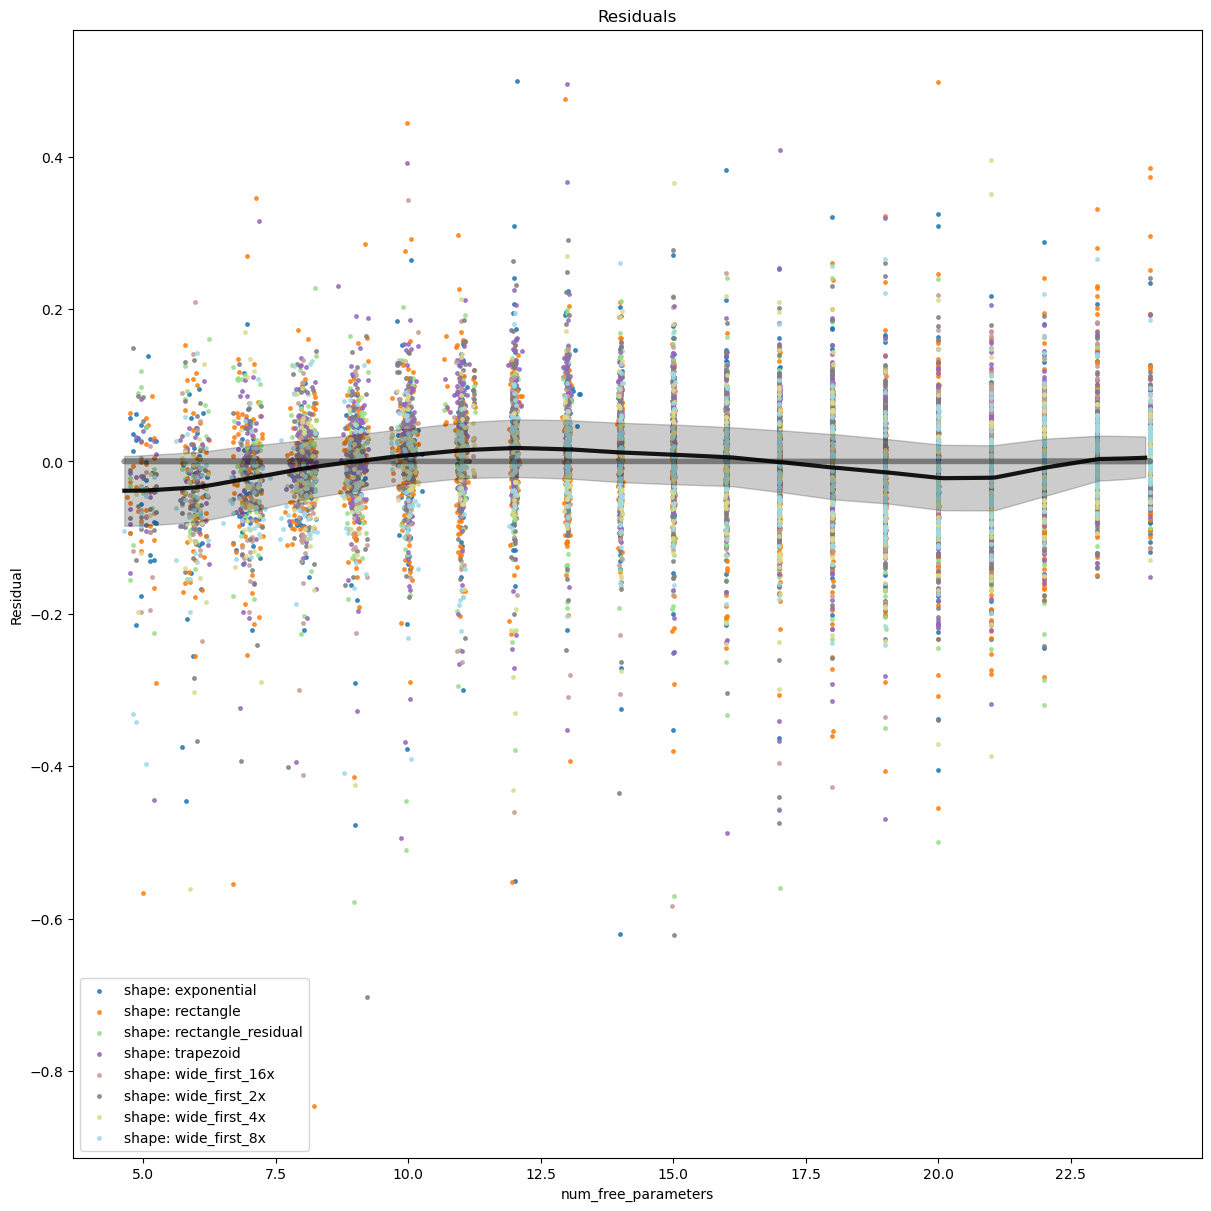

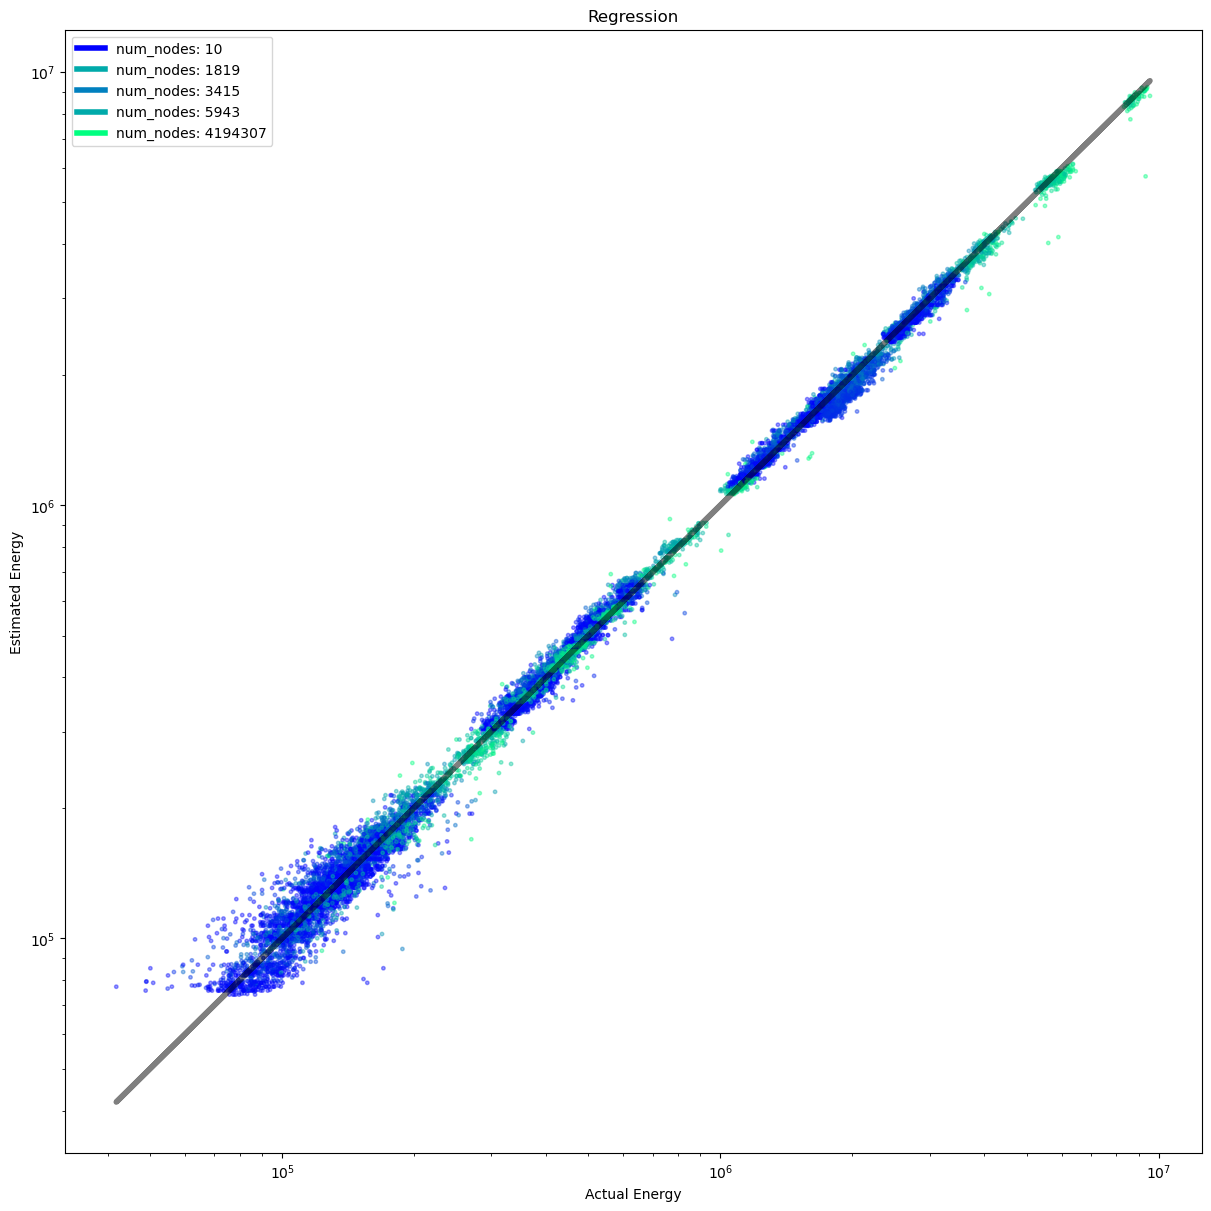

3.321928094887362 22.000001031895536 200


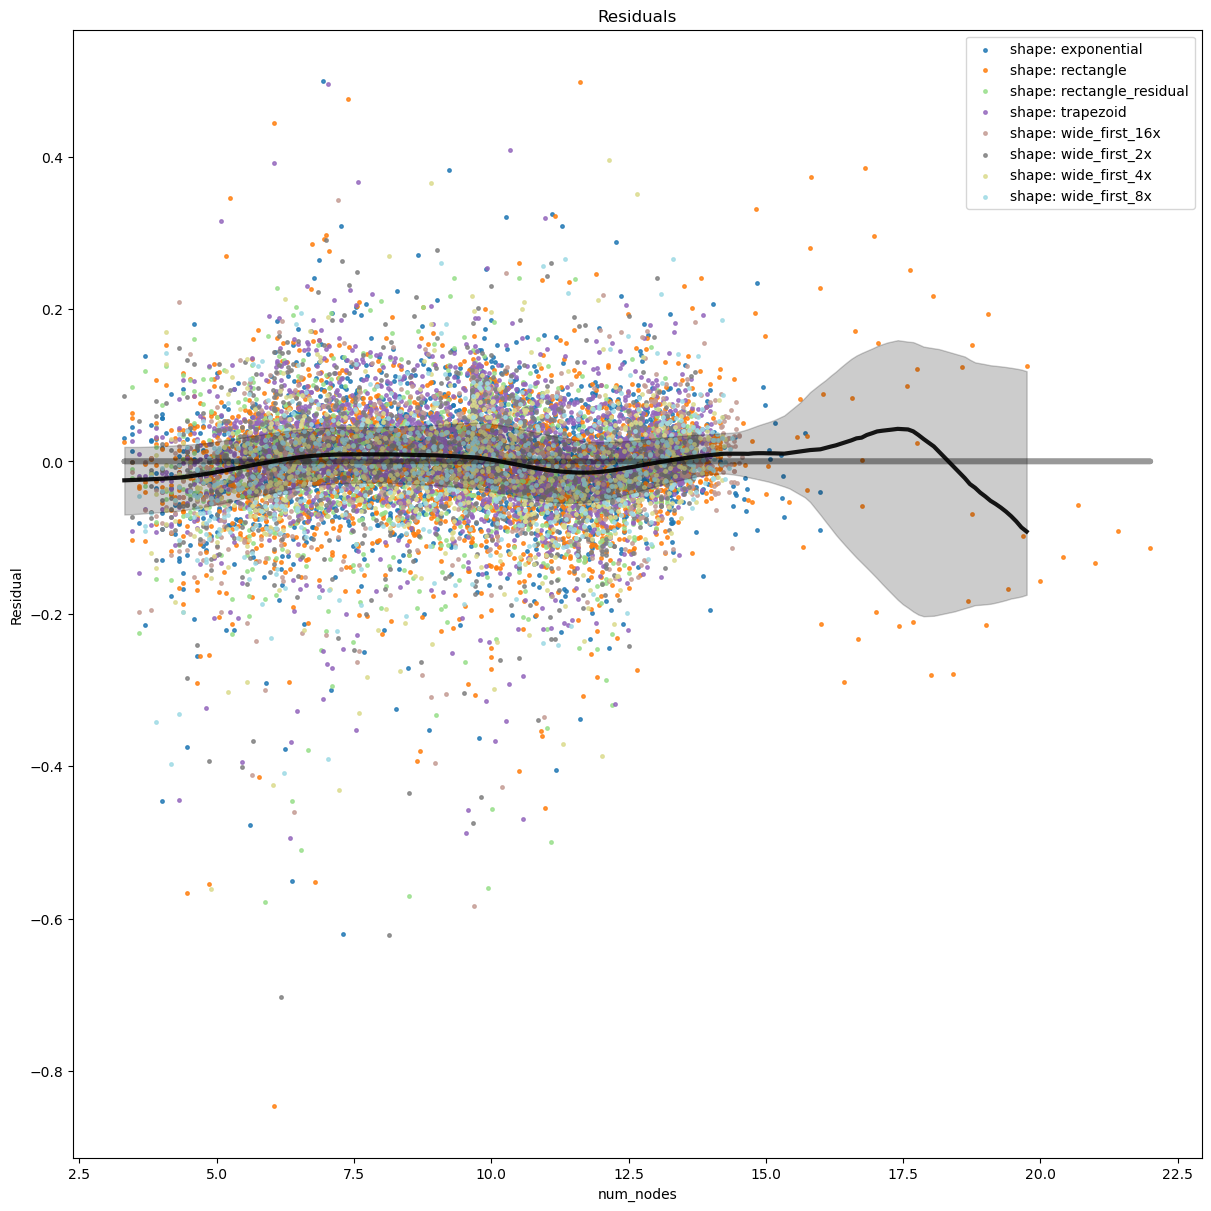

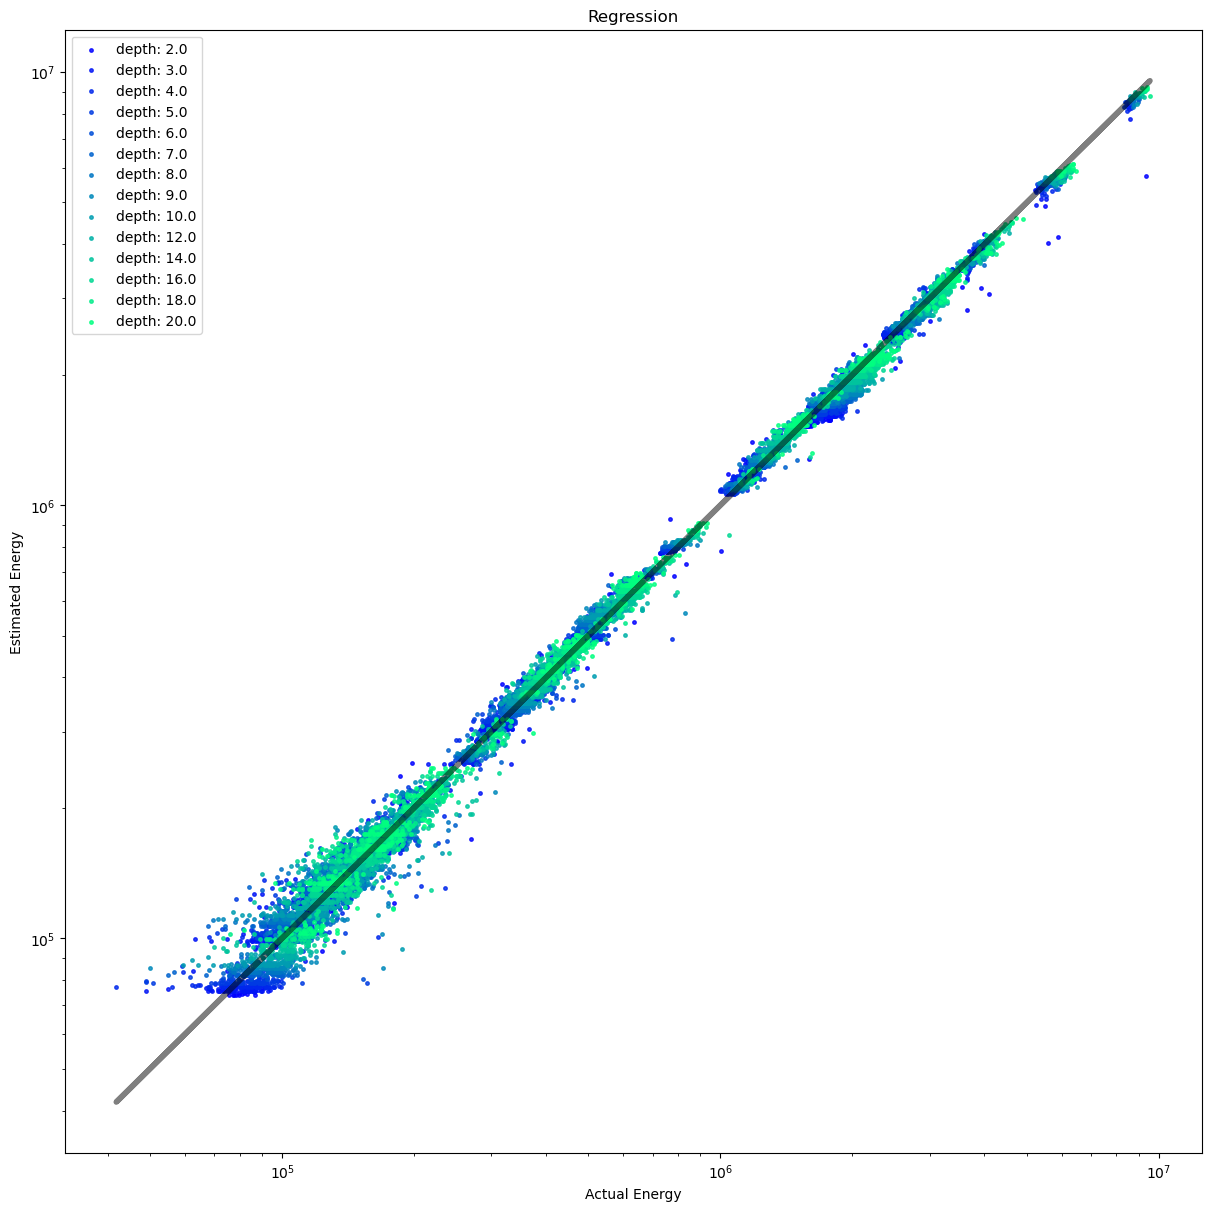

1.0 4.321928094887363 200


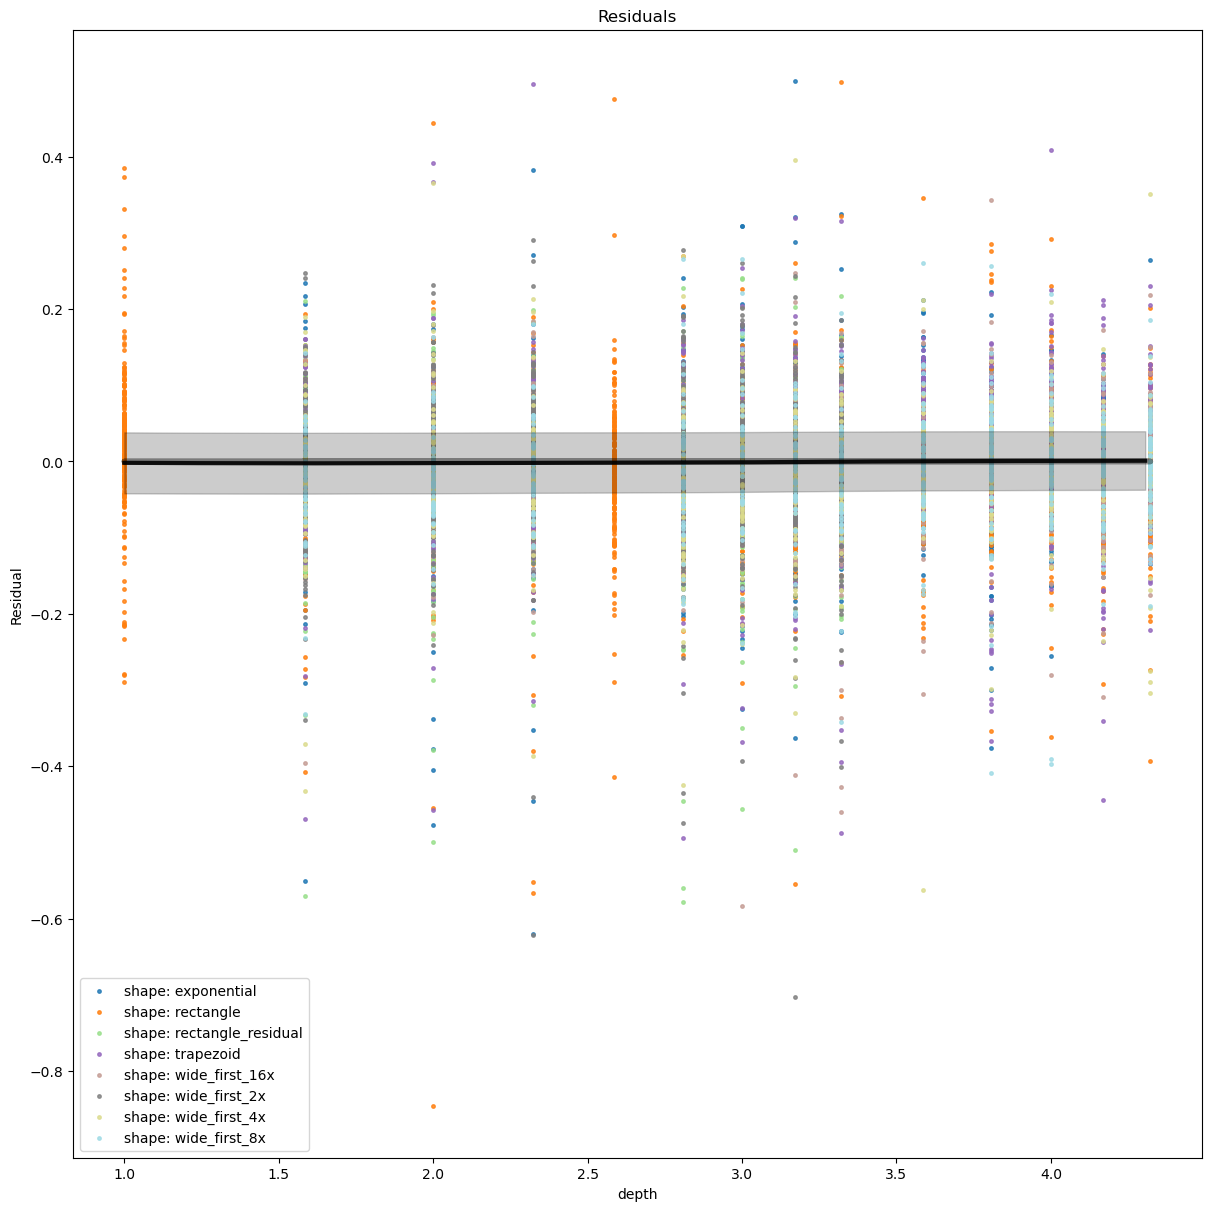

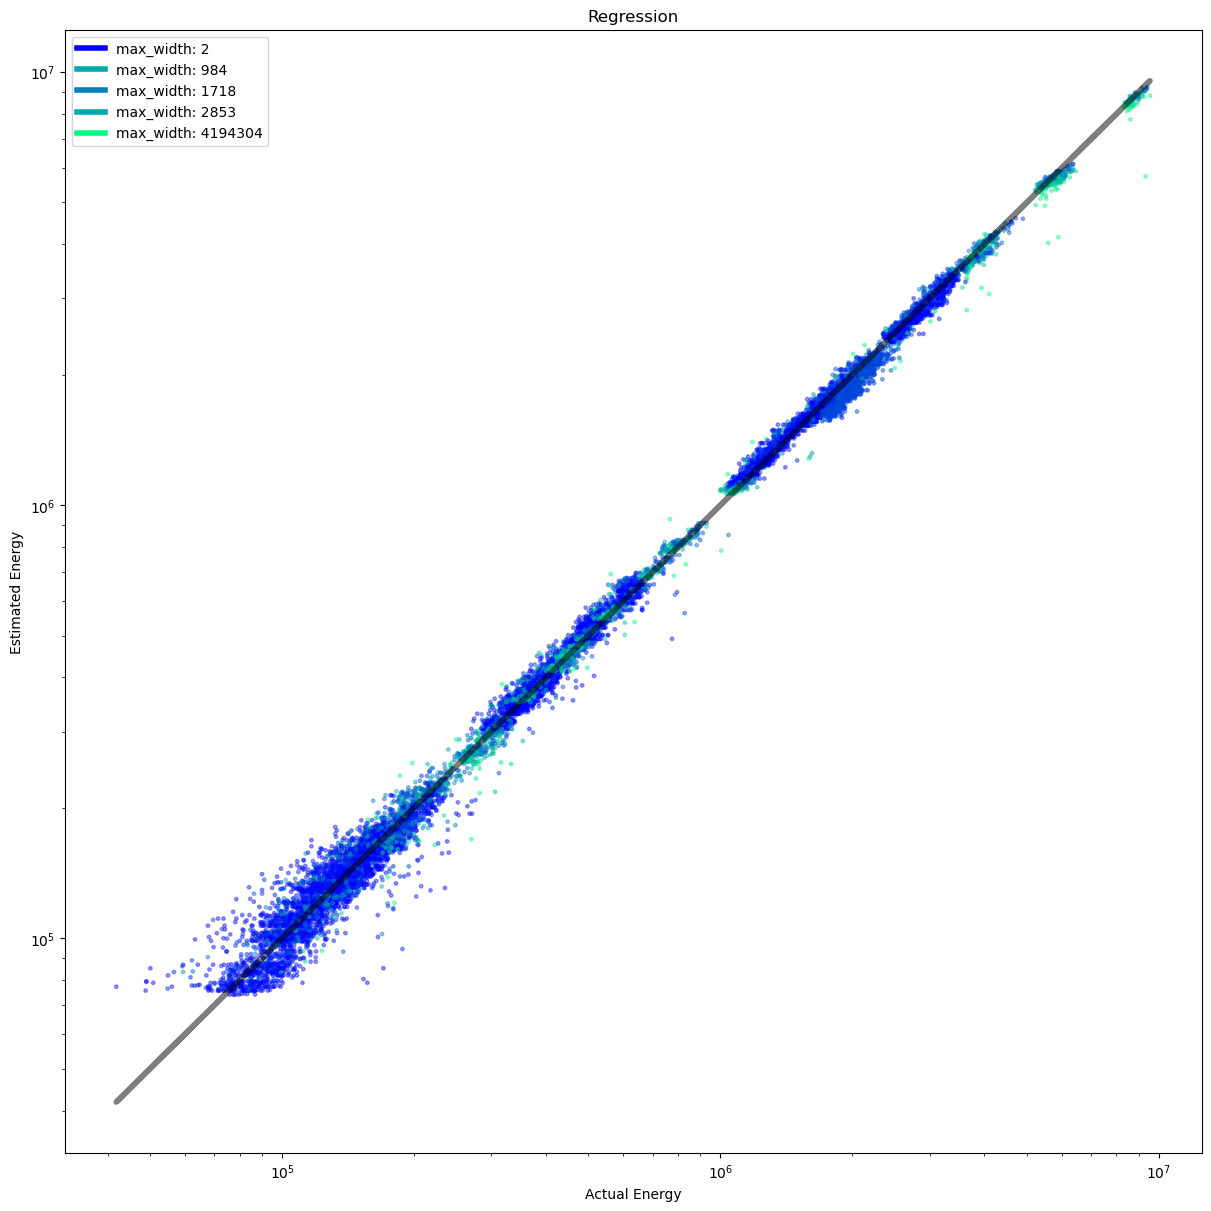

1.0 22.0 200


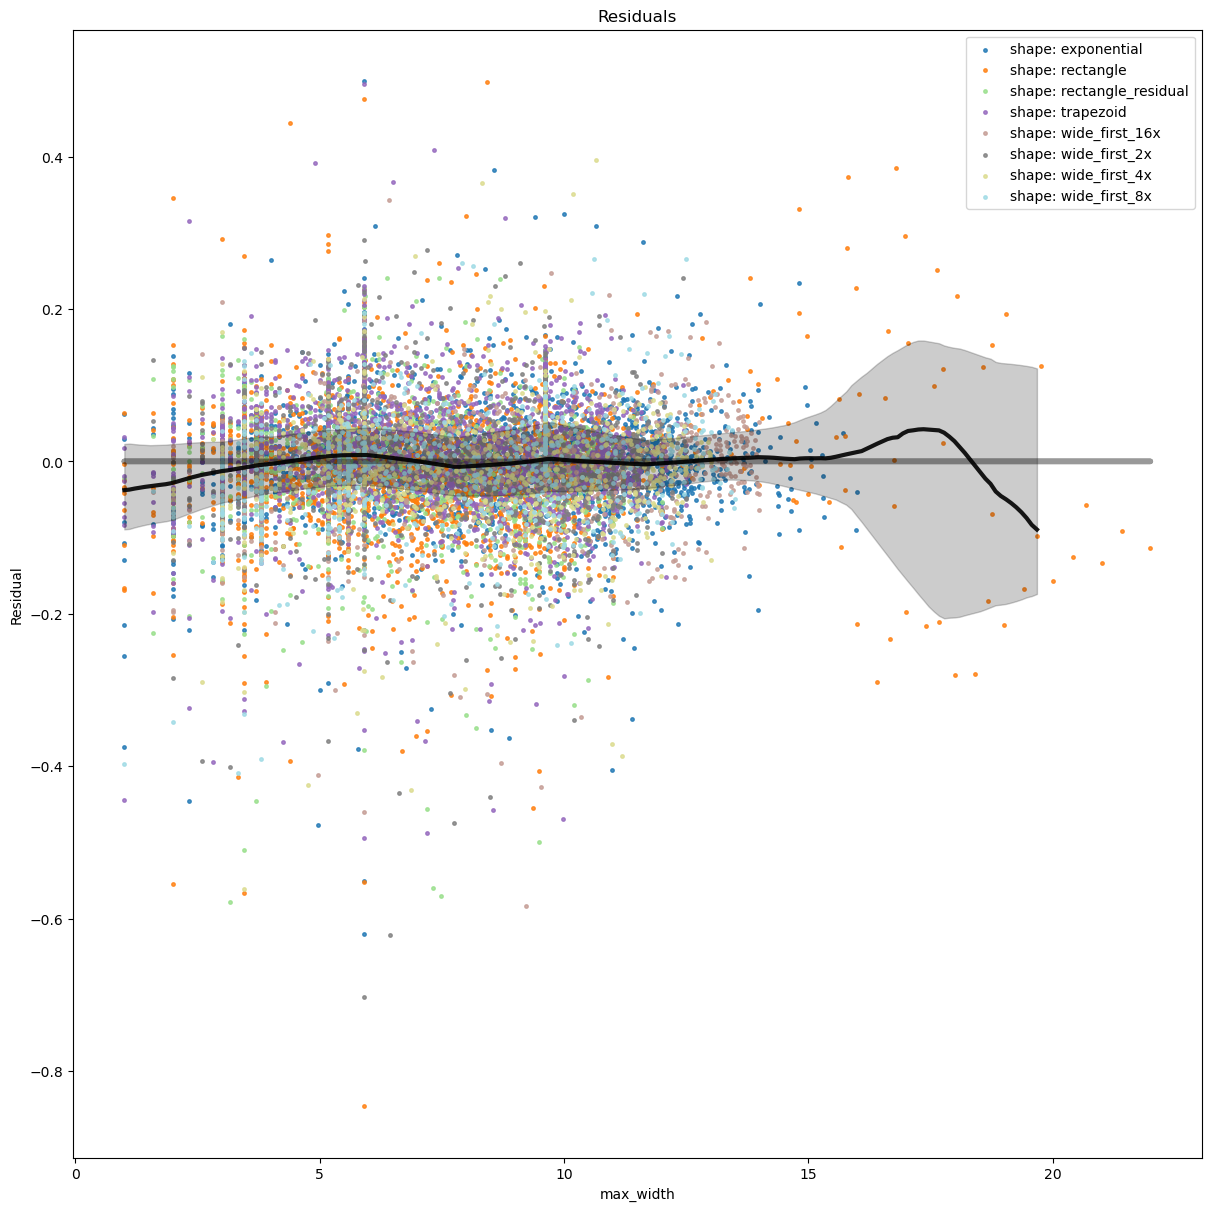

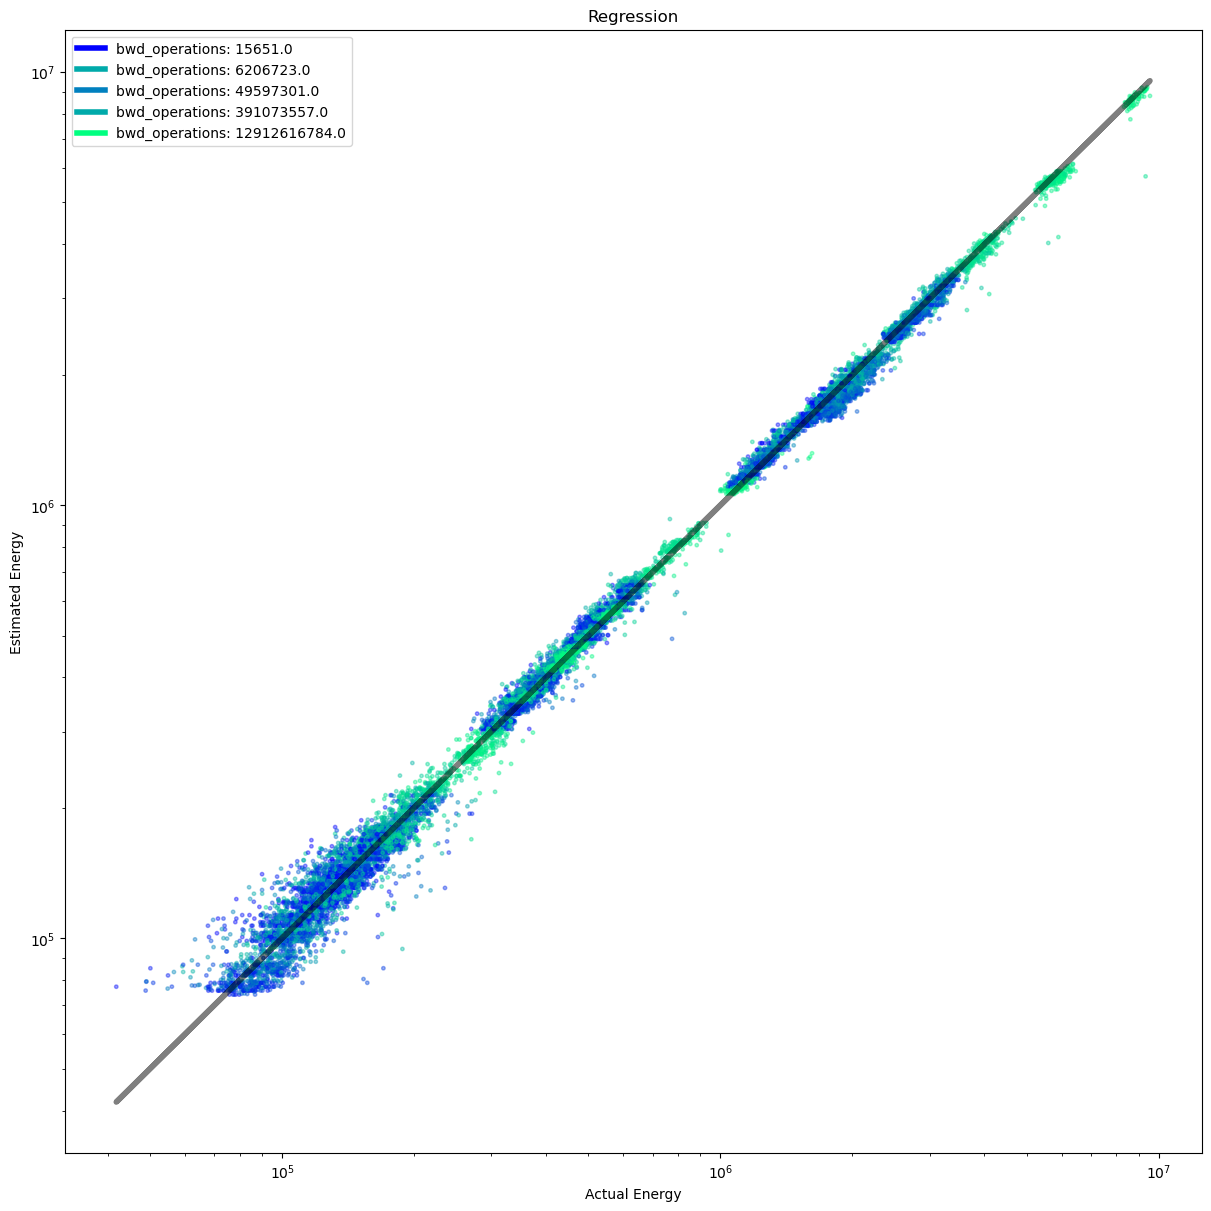

13.933967218748899 33.588062346013196 200


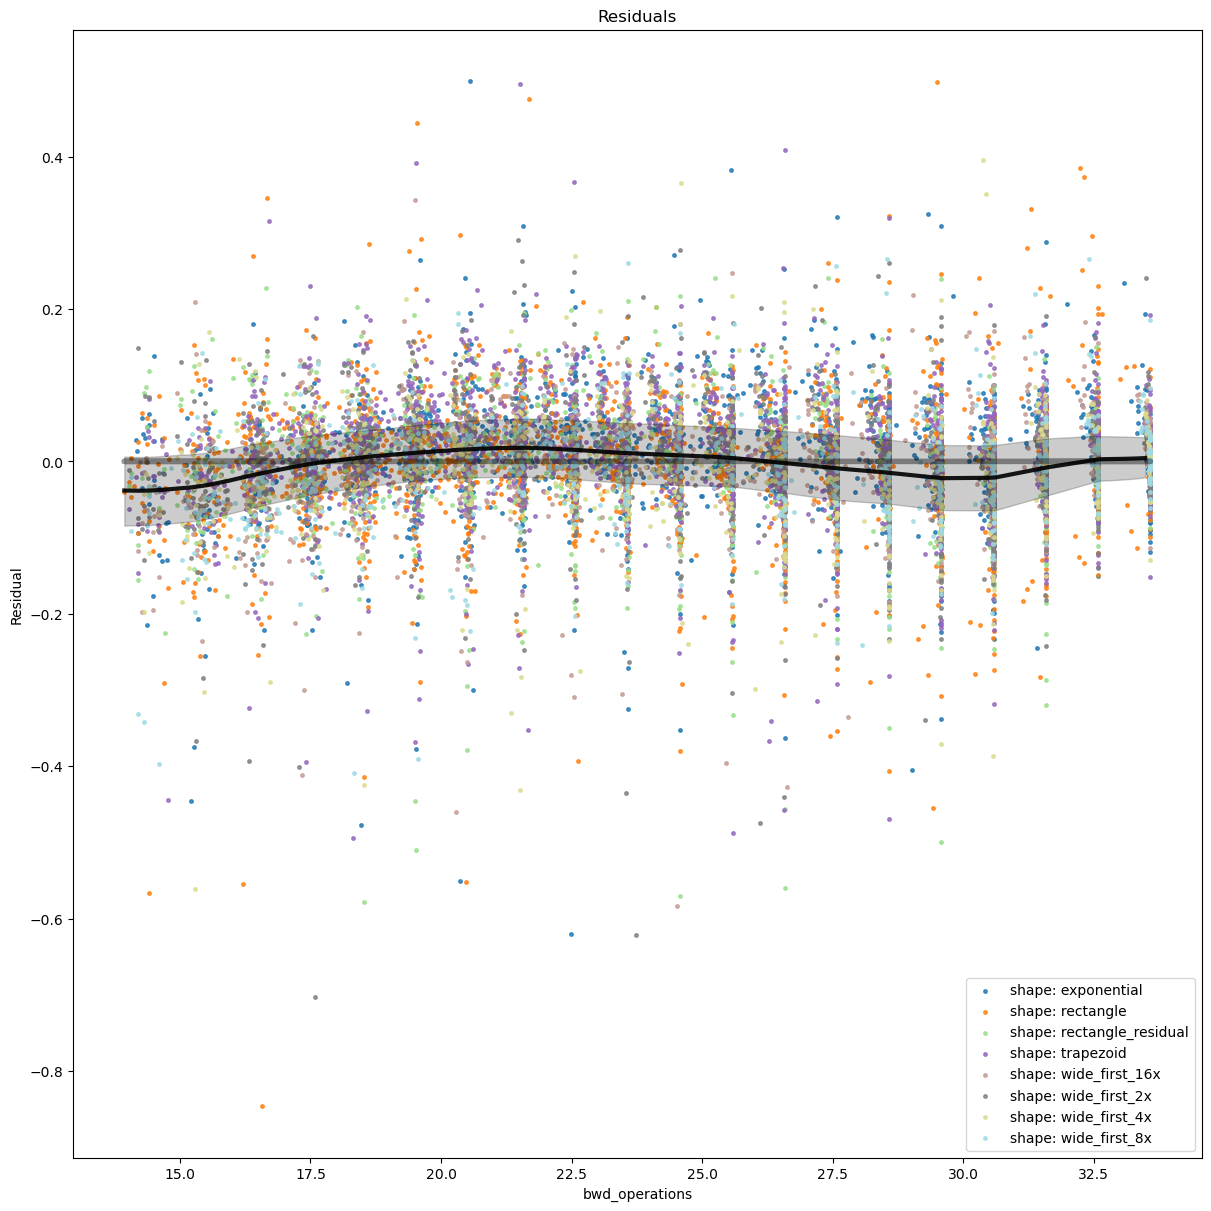

In [10]:
for v in [
    "num_free_parameters",
    "num_nodes",
    "depth",
    # "fwd_model_total_ws_size",
    "max_width",
    "bwd_operations",
    # "non_overhead_power",
]:
    plot_regression(gpu_experiments, v)
    plot_regression_residual(gpu_experiments, v, "shape")

In [11]:
cpu_experiments = (
    experiments.query('has_gpu == 0 and dataset not in ("505_tecator")')
    .copy()
    .reset_index(drop=True)
)

cpu_result, cpu_estimation_function, cpu_experiments = fit_model(
    cpu_experiments, cpu_caches, 0
)
cpu_parameters = make_parameter_values(cpu_caches, cpu_result)
# 20.0207977463953%
# 20.21470872930401%

[(0, -3782.553826076284),
 (1, 1461.2442718374175),
 (2, 758.1952989080438),
 (3, 8.215186864695431),
 (4, 1.6958969013425896e-15),
 (5, 59.32281499310816),
 (6, 216.48019337192738),
 (7, 302.77724473773566),
 (8, 2.2206422519684716e-20),
 (9, 22.67664917695658),
 (10, 21.43654953127157),
 (11, 35.43453542304466)]
error: 0.2202041021239984 22.461584636868853%
[('k_e', -3782.553826076284),
 ('k_p', 1461.2442718374175),
 ('k_o', 758.1952989080438),
 ('k_d', 8.215186864695431),
 ('a_1', 1.6958969013425896e-15),
 ('a_2', 59.32281499310816),
 ('a_3', 216.48019337192738),
 ('a_4', 302.77724473773566),
 ('m_1', 2.2206422519684716e-20),
 ('m_2', 22.67664917695658),
 ('m_3', 21.43654953127157),
 ('m_4', 35.43453542304466)]


In [12]:
gpu_parameter_values_map = {n: v for n, v in gpu_parameters}
pprint([(n, c, gpu_parameter_values_map.get(n, 0.0)) for n, c in cpu_parameters])

[('k_e', -3782.553826076284, 614.4530033811986),
 ('k_p', 1461.2442718374175, 3077.6164787571547),
 ('k_o', 758.1952989080438, 889.8504700398178),
 ('k_d', 8.215186864695431, 33.08340239086024),
 ('a_1', 1.6958969013425896e-15, 16.397627884684717),
 ('a_2', 59.32281499310816, 19.770274134099086),
 ('a_3', 216.48019337192738, 4.979016243554132e-25),
 ('a_4', 302.77724473773566, 0.0),
 ('m_1', 2.2206422519684716e-20, 2.4519218164303315e-29),
 ('m_2', 22.67664917695658, 4.346489120617996e-28),
 ('m_3', 21.43654953127157, 5.715811019061141),
 ('m_4', 35.43453542304466, 0.0)]


(99,)
(100,)
mean: 1.0030474199687092 std: 0.07909853928226404
mean_relative_error 2.7422644176950755%
(array([201.74337522]), array([[26.41476572]]))
(99,)
(100,)
mean: 1.0371203909282576 std: 0.27426117854681203
mean_relative_error 20.211050263908763%
(array([276.92850898]), array([[31.57870684]]))


/tmp/ipykernel_56730/375977394.py:62: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for h in legend.legendHandles:


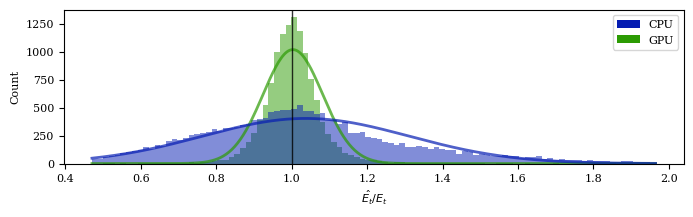

In [13]:
plt.rcParams["font.size"] = 8
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.labelsize"] = 8

fig, ax = plt.subplots(
    1,
    1,
    figsize=(8, 2),
)

cpu_error_ratio = (
    cpu_experiments["estimated_energy"] / cpu_experiments["non_overhead_energy"]
)
xlim = tuple(np.quantile(cpu_error_ratio, [0.01, 0.99]))
bins = np.linspace(*xlim, 100)


def plot_errors(e, color):

    error_ratio = e["estimated_energy"] / e["non_overhead_energy"]

    # d = e.loc[error_ratio.between(*xlim)]
    error_ratio = error_ratio.loc[error_ratio.between(*xlim)]

    (counts, _) = np.histogram(error_ratio, bins=bins)
    hist_out = ax.hist(error_ratio, bins=bins, alpha=0.5, color=color)
    print(counts.shape)
    print(bins.shape)

    m = np.mean(error_ratio)
    sigma = np.std(error_ratio)

    print(f"mean: {m} std: {sigma}")
    mean_relative_error = 100 * np.mean(
        np.abs(e["estimated_energy"] - e["non_overhead_energy"]) / e["std_energy"]
    )
    print(f"mean_relative_error {mean_relative_error}%")

    popt = scipy.optimize.curve_fit(
        lambda x, s: s * scipy.stats.norm.pdf(x, m, sigma),
        (bins[1:] + bins[:-1]) / 2,
        counts,
    )
    print(popt)

    x = np.linspace(*xlim, 400)
    plt.plot(
        x, popt[0] * scipy.stats.norm.pdf(x, m, sigma), color=color, lw=2, alpha=0.7
    )
    return hist_out


gpu_hist = plot_errors(gpu_experiments, gpu_color)
cpu_hist = plot_errors(cpu_experiments, cpu_color)


ax.axvline(1.0, color="k", lw=1, alpha=0.8)
ax.set_ylabel("Count")
ax.set_xlabel("$\hat{E_t}/E_t$")

legend = ax.legend([cpu_hist[2][0], gpu_hist[2][0]], ["CPU", "GPU"])
for h in legend.legendHandles:
    h.set_alpha(1.0)

fig.savefig("./figures/8_model_error.svg", dpi=600, bbox_inches="tight")
fig.savefig("./figures/8_model_error.png", dpi=600, bbox_inches="tight")

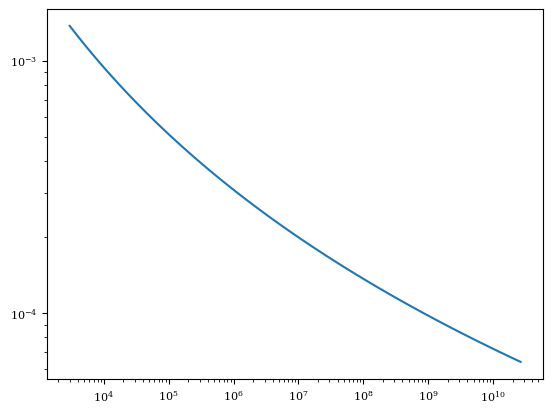

In [14]:
p = np.exp(np.linspace(8, 24, 100))
e = np.power(np.log(p) + 1, -3)
plt.plot(p, e)
plt.xscale("log")
plt.yscale("log")

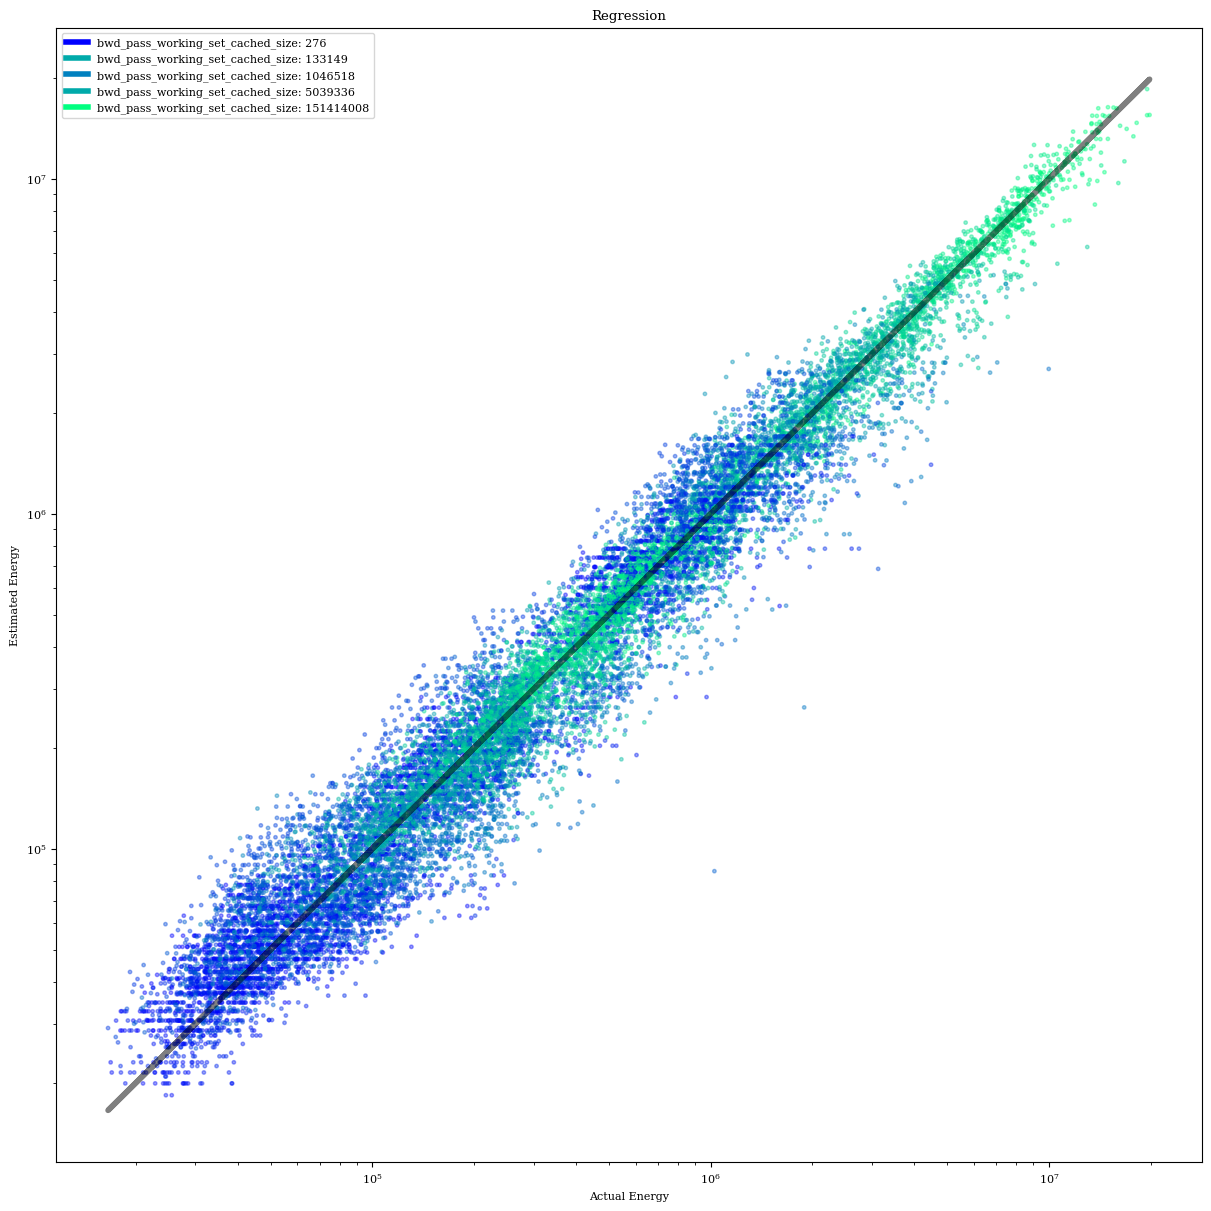

8.108524456778168 27.173923440890693 200


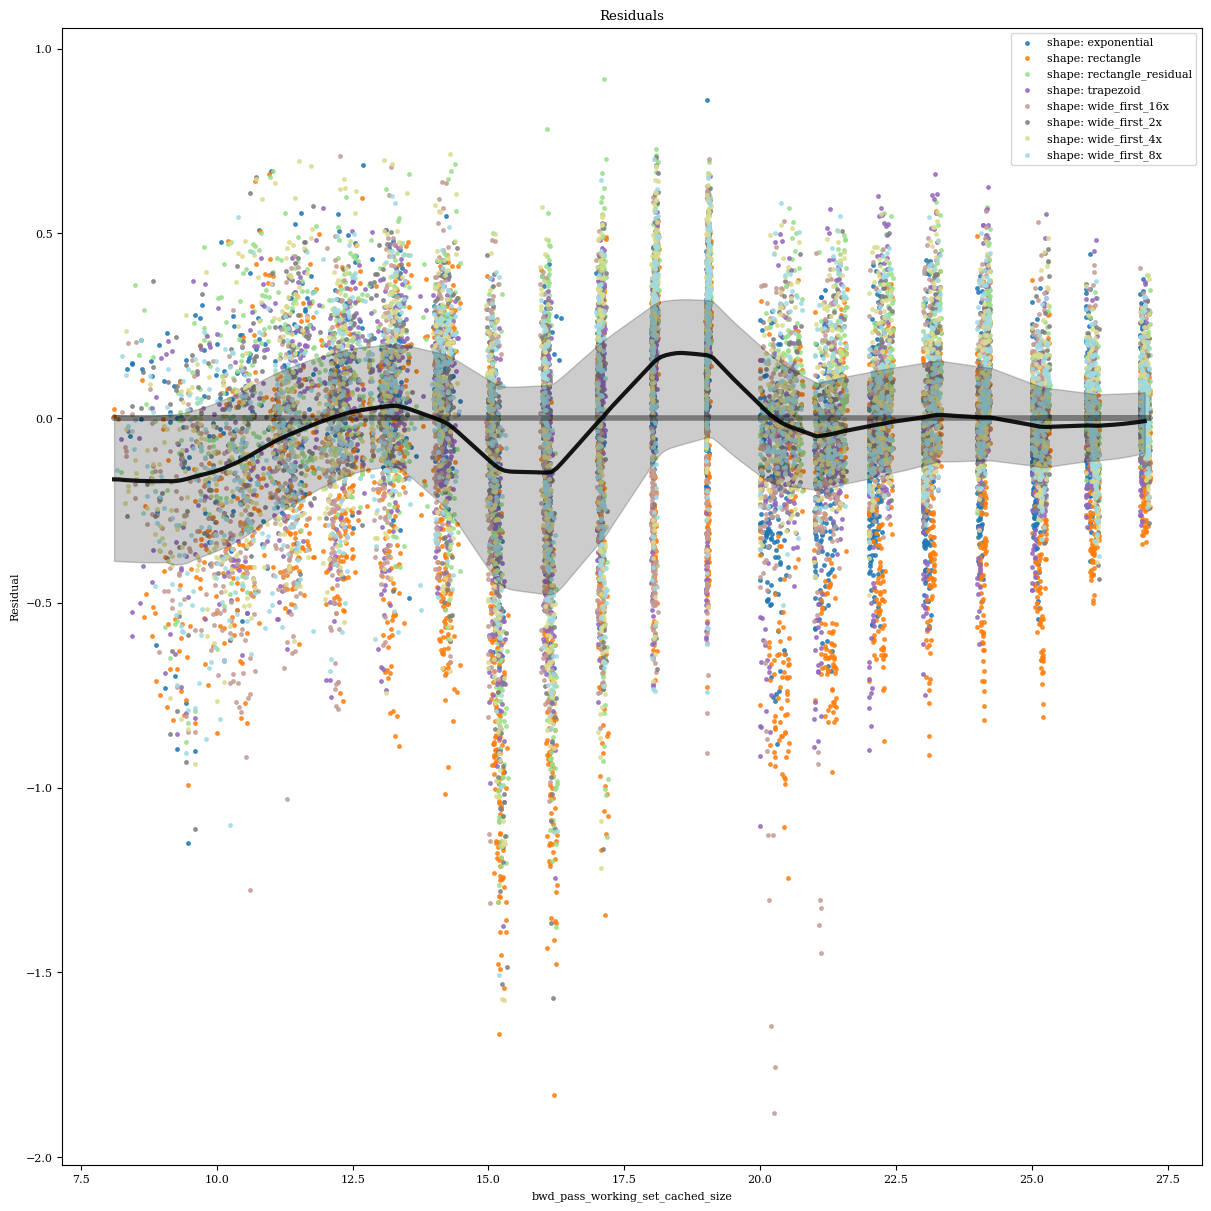

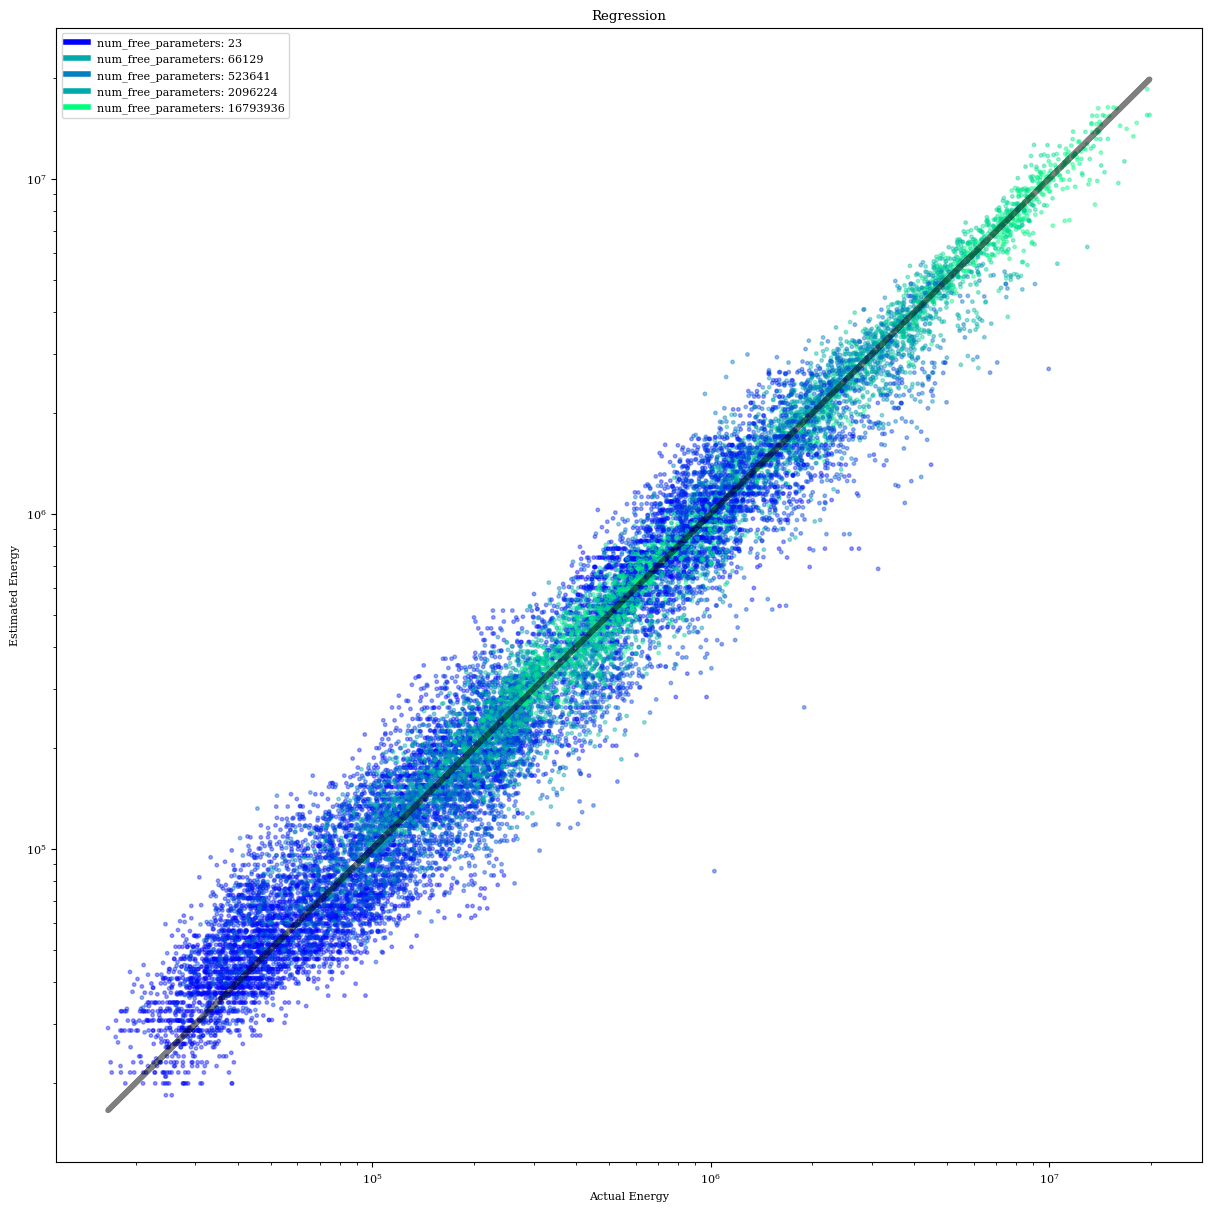

4.523561956057013 24.001437059001024 200


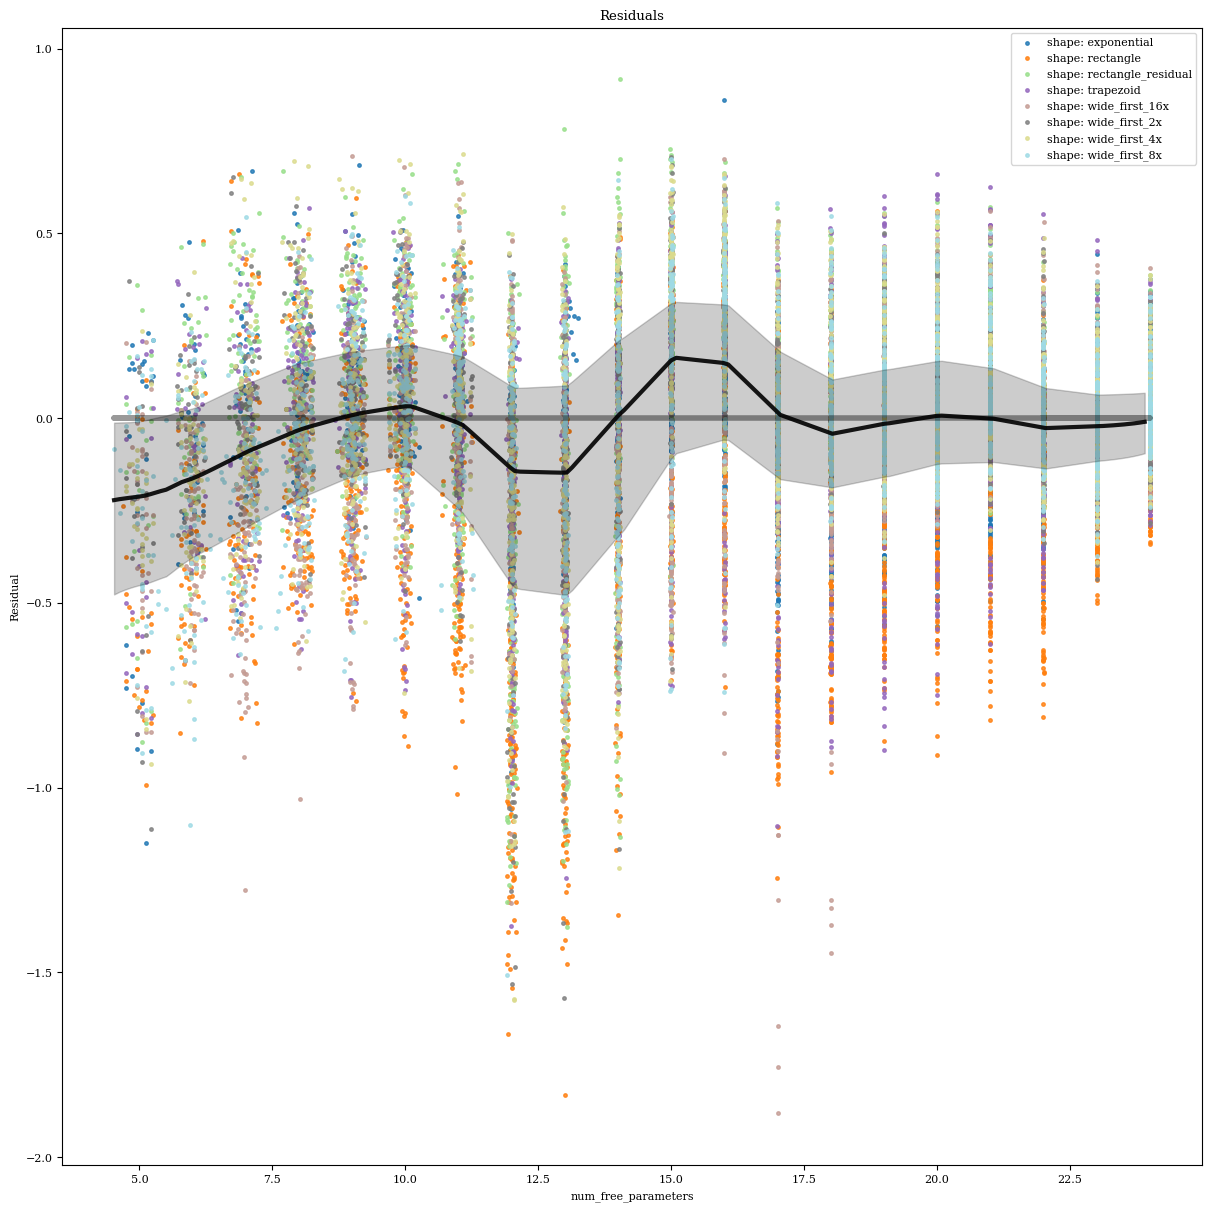

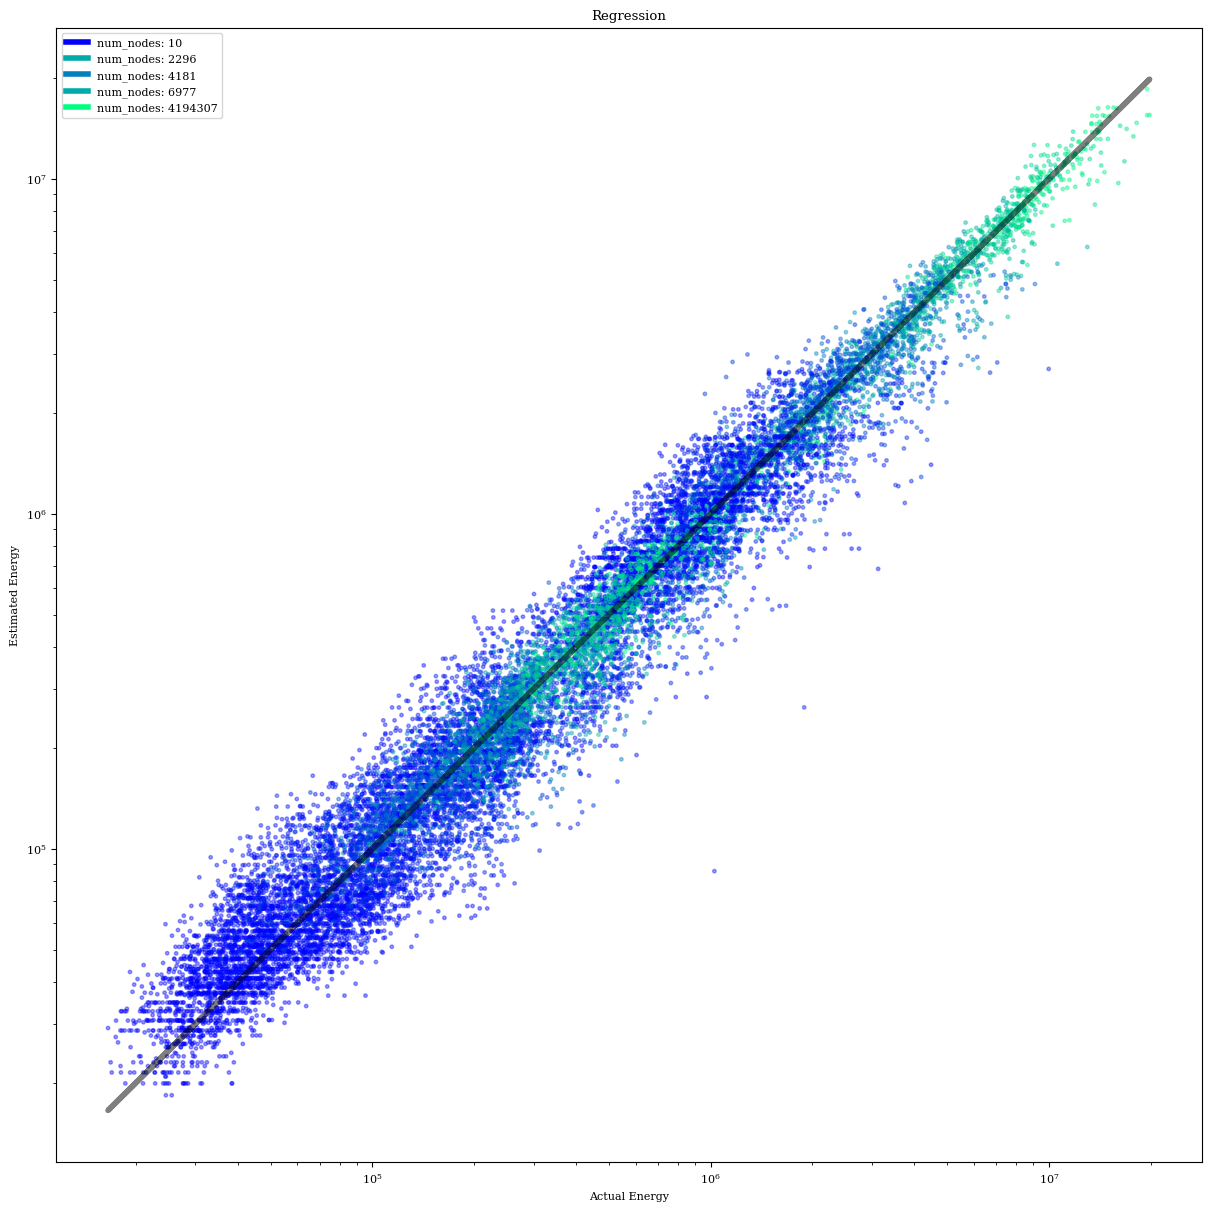

3.321928094887362 22.000001031895536 200


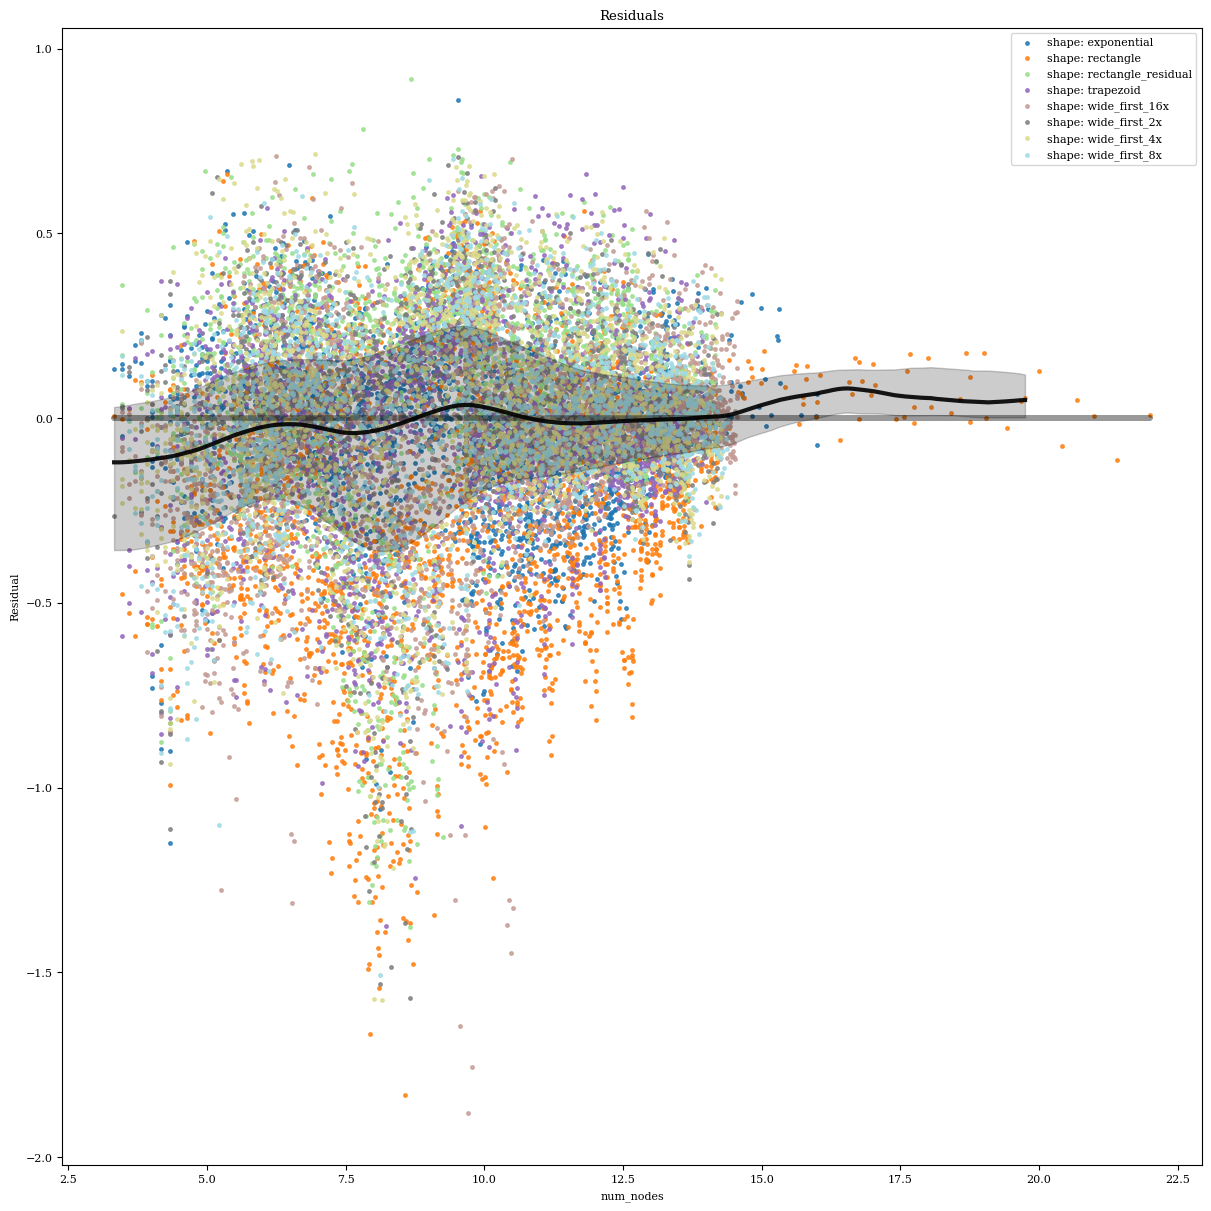

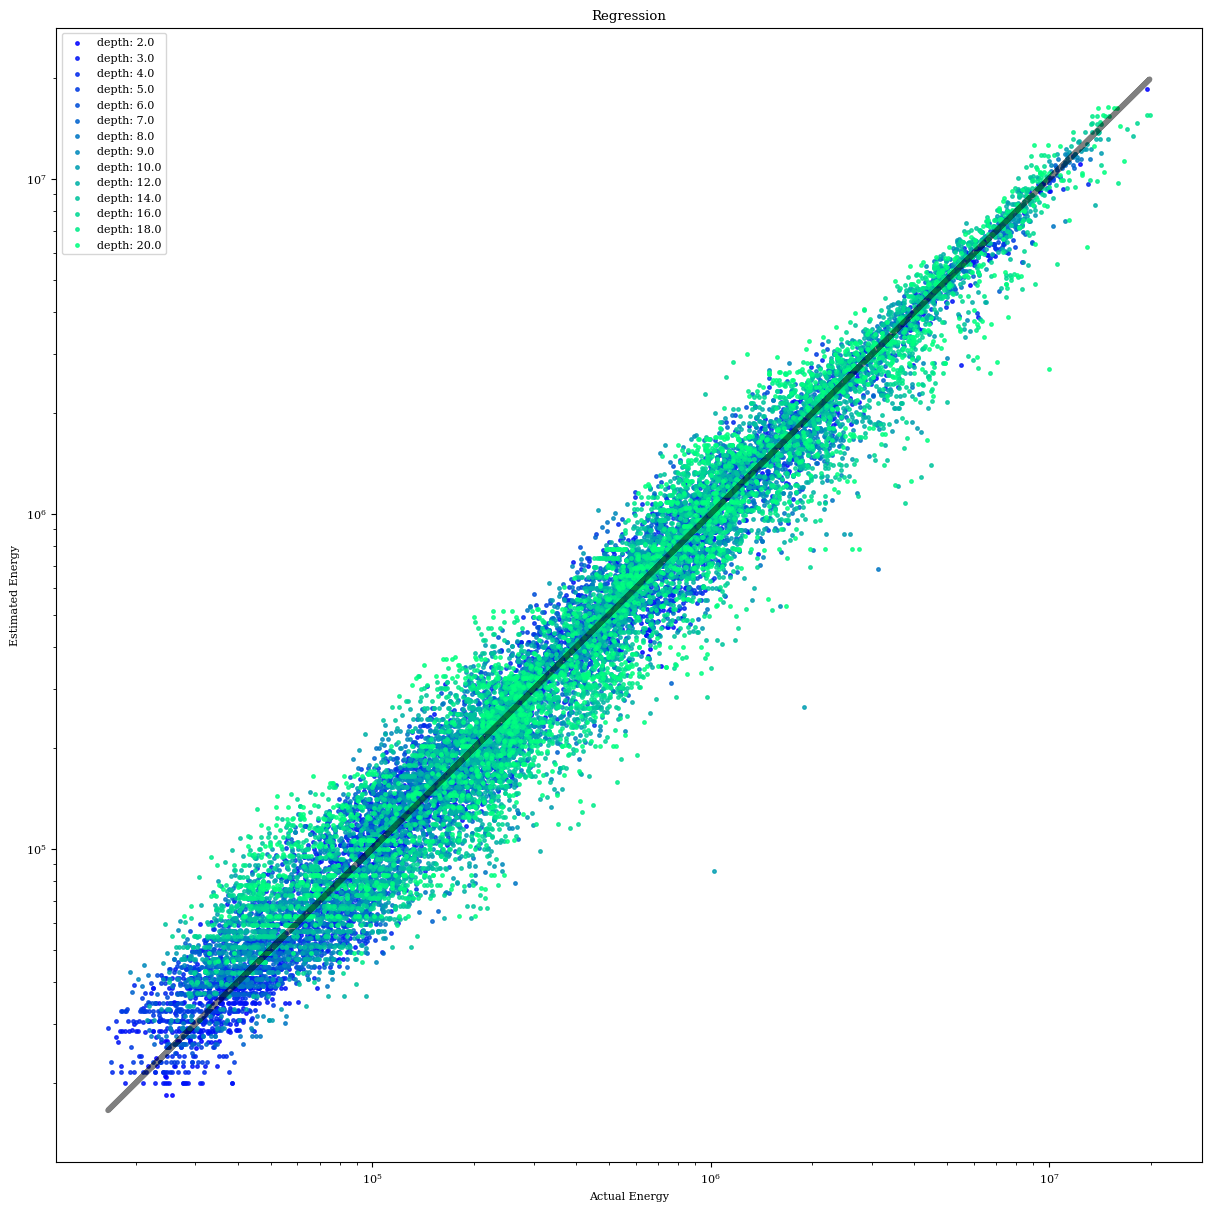

1.0 4.321928094887363 200


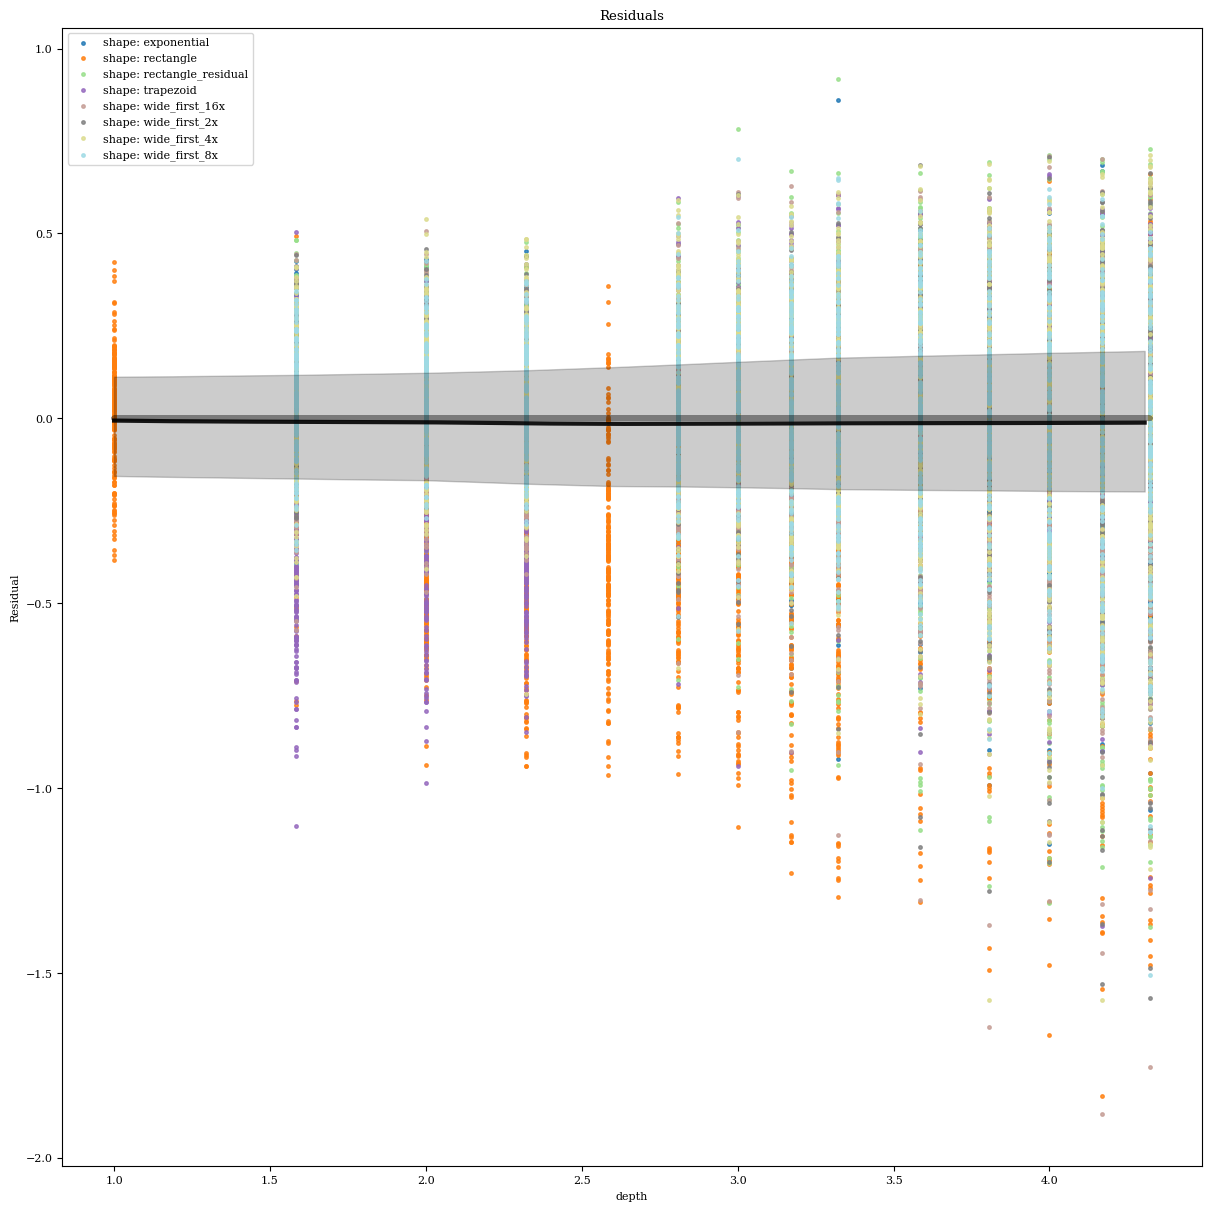

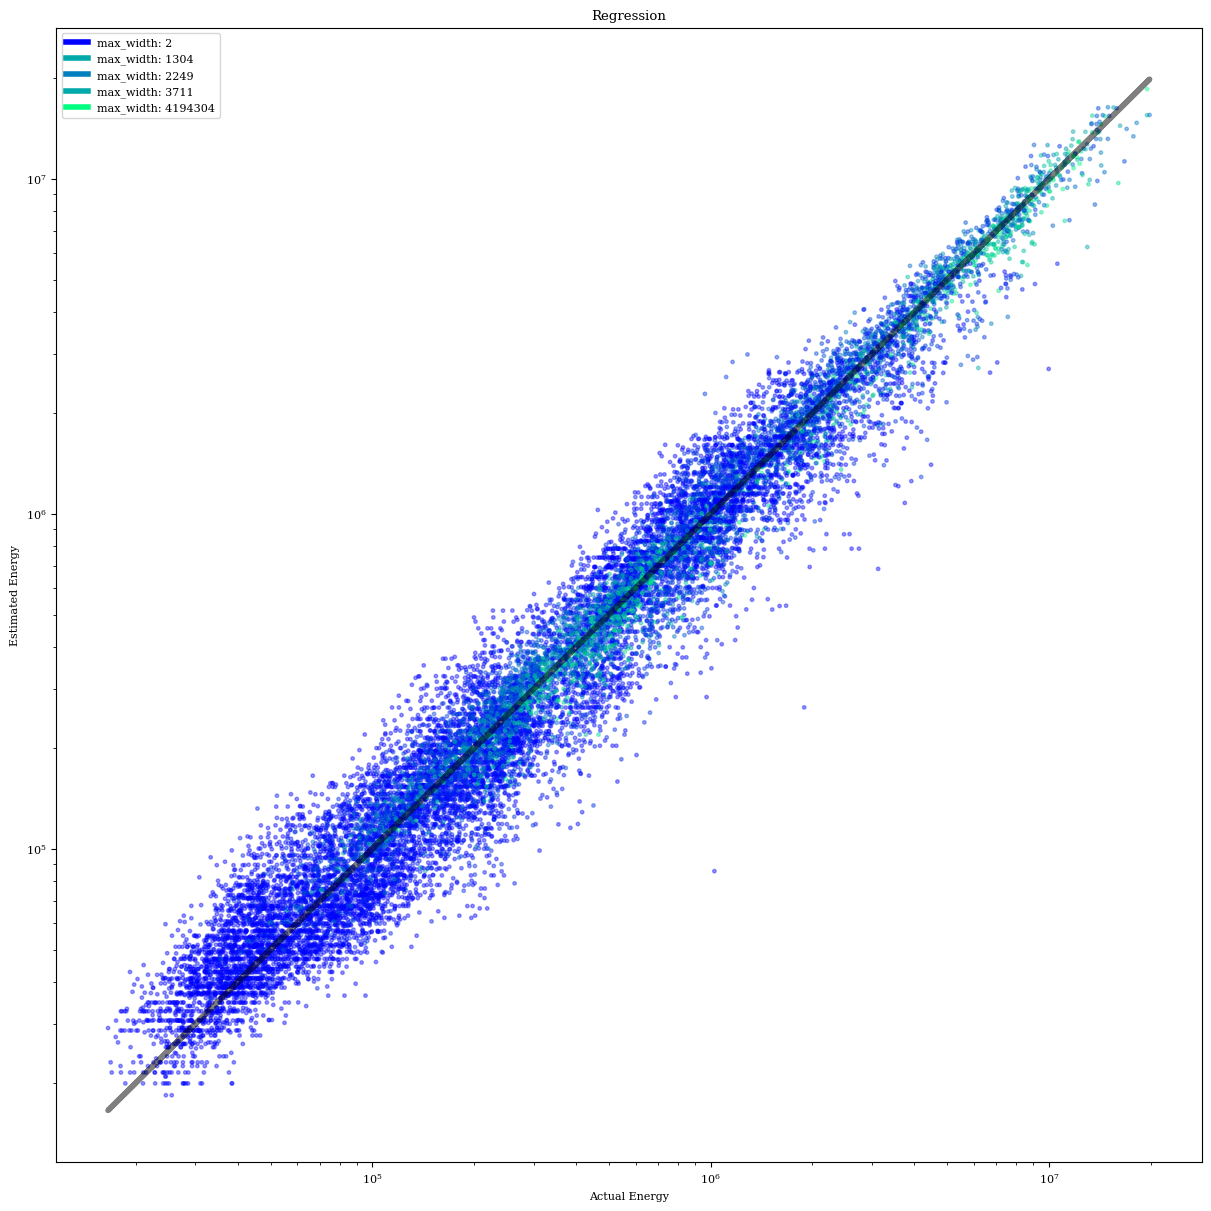

1.0 22.0 200


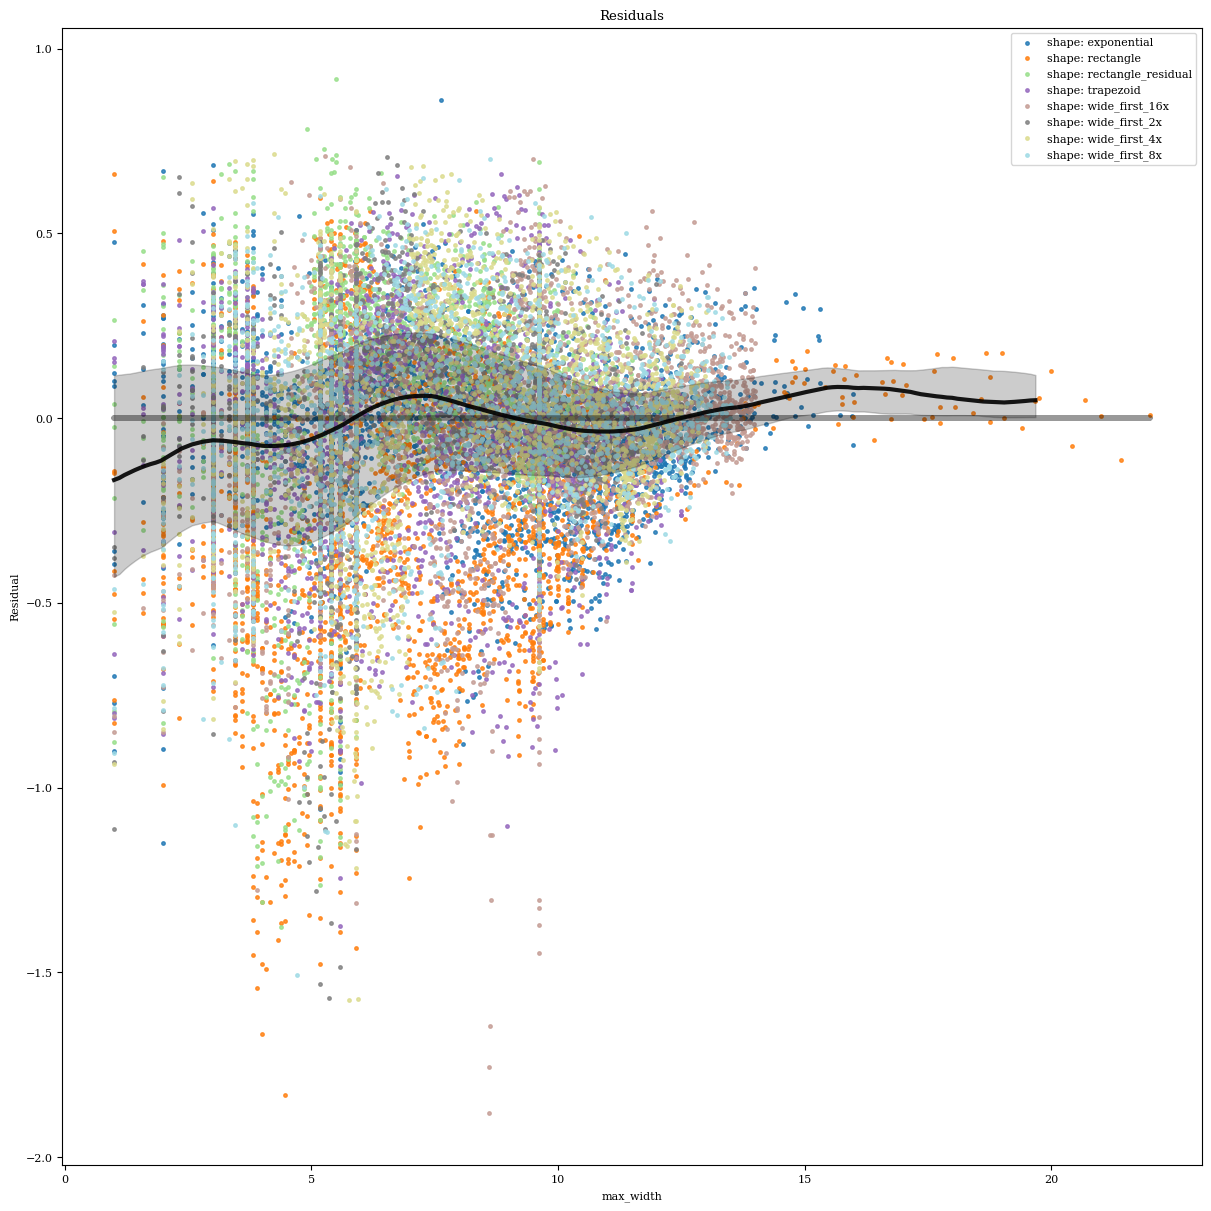

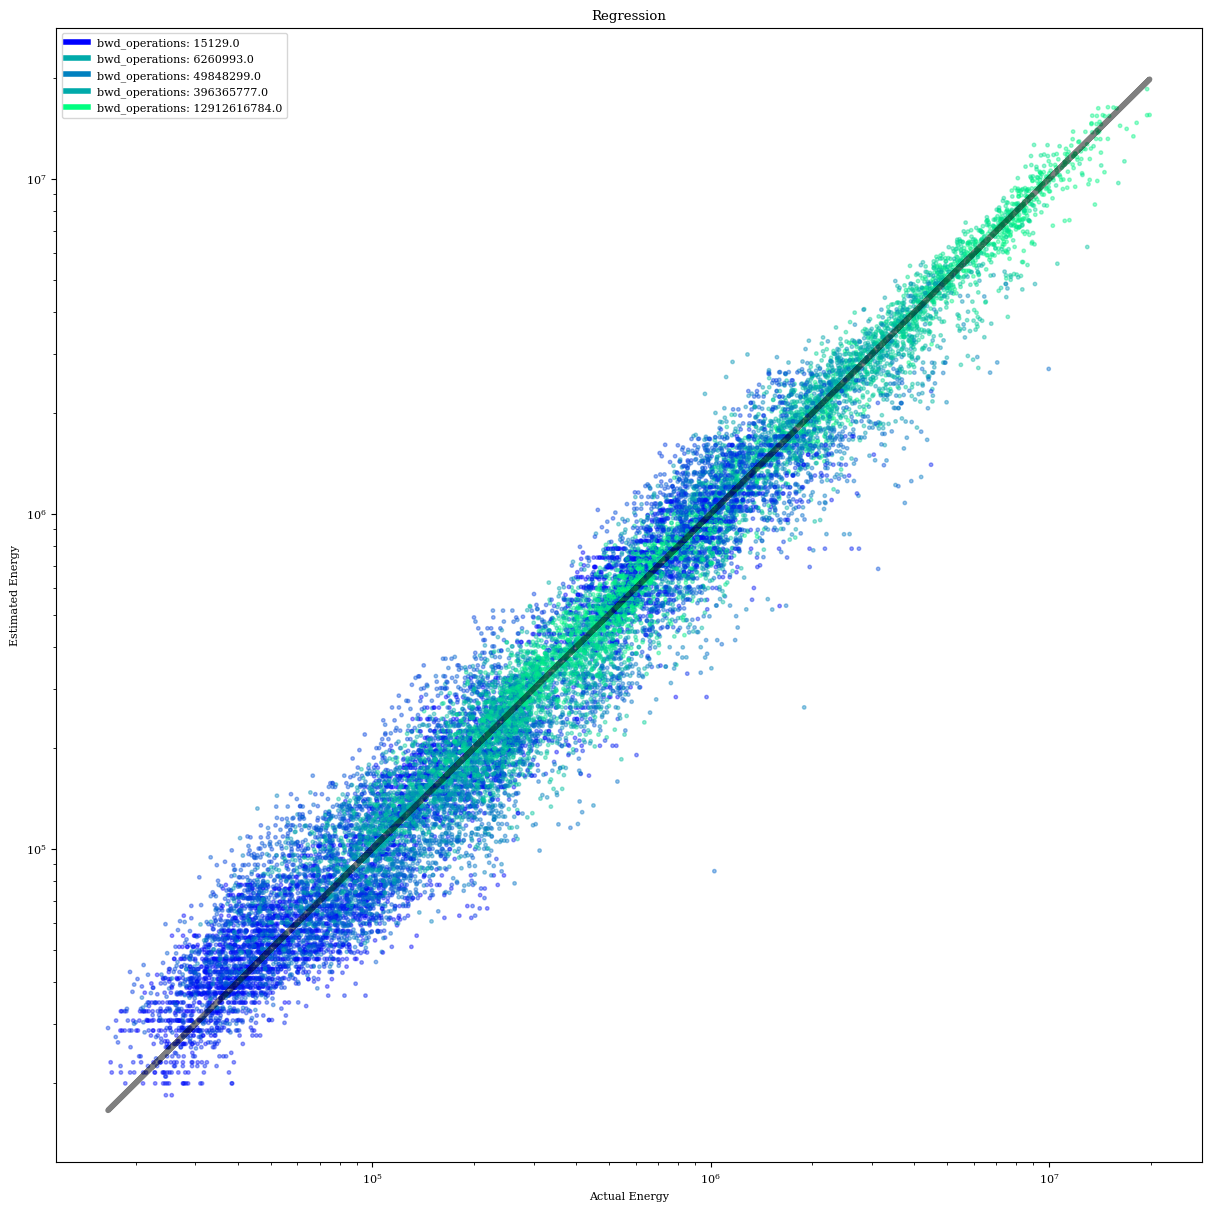

13.88502901067848 33.588062346013196 200


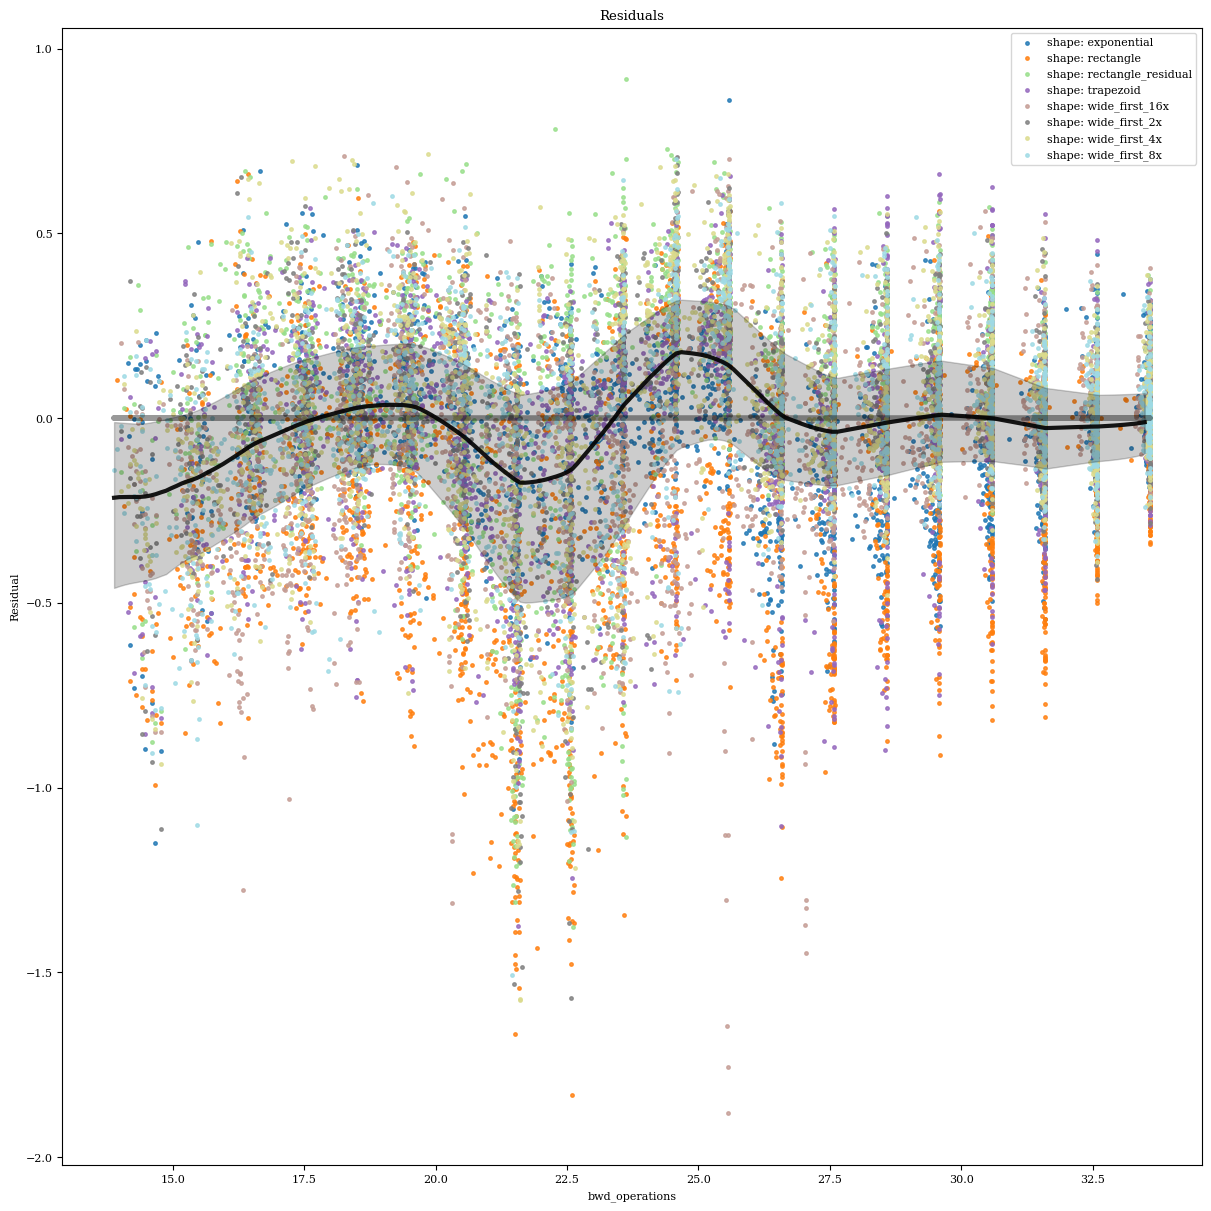

In [15]:
for v in [
    "bwd_pass_working_set_cached_size",
    "num_free_parameters",
    "num_nodes",
    "depth",
    # "fwd_model_total_ws_size",
    "max_width",
    "bwd_operations",
    # "non_overhead_power",
]:
    plot_regression(cpu_experiments, v)
    plot_regression_residual(cpu_experiments, v, "shape")